In [1]:
from scipy.io import wavfile 
capstone_dir = "/Users/ninismacbook/other_docs/Y4S1+S2/capstone" 
import matplotlib.pyplot as plt; import numpy as np; import pandas as pd ; import librosa
import librosa.display # Must have
from dtw import dtw; import scipy.stats
import math

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Everything together - 13 MFCCs

In [2]:
def normalize(mfcc):
    
    matrix = np.zeros((mfcc.shape))
    
    for i in range(mfcc.shape[0]):
        array = mfcc[i, :]
        mean = np.mean(array)
        sd = np.std(array)
        
        for j in range(mfcc.shape[1]):
            new_val = (mfcc[i, j]-mean)/sd
            if new_val > 2:
                new_val == 2
            if new_val < -2:
                new_val == -2
            matrix[i, j] = new_val/5 + 0.5
    return matrix

# print(normalize(np.array([[-3, -2, -1], [3, 2, 3]])))

In [3]:
# deviation function
def deviation(rho, theta):
    dev = 0
    if rho >= theta and rho <= math.pi/2:
        dev = (rho-theta)/(math.pi/2-theta)
    else:
        dev = (theta - rho)/theta
    return dev

In [4]:
def remove_short_pauses(speech_array, min_pause_len_s, mfcc_len_s_1): # filter out pauses shorter than min_pause_len_s in speech array
    
    sp_transitions = []     
    for s in range(len(speech_array)-1):
        if s > 0 and s < len(speech_array):
            if speech_array[s] == 0 and speech_array[s+1] == 1:
                sp_transitions.append(s)
            if speech_array[s] == 1 and speech_array[s+1] == 0:
                sp_transitions.append(s)
    
    for t in range(len(sp_transitions)-1):
        if (sp_transitions[t+1] - sp_transitions[t])*mfcc_len_s_1 < min_pause_len_s:
            speech_array[sp_transitions[t]:sp_transitions[t+1]] = [1]*(sp_transitions[t+1]-sp_transitions[t])
            
    return speech_array

In [5]:
def speech(smooth_query, original_query, seg1_1, seg1_2, samplerate, frame_per_window, **kwargs):

    input_min_amp = kwargs.get('input_min_amp', None)
    input_min_pause = kwargs.get('input_min_pause', 50)    # unit = ms
    
    if input_min_amp == None:
        abs_q = np.abs(smooth_query[int(samplerate*0.5): int(samplerate*1.5)])    
        default_min_amp = np.max(abs_q)
        print('Default amplitude threshold: ', default_min_amp)
        min_amp = default_min_amp
    else:
        min_amp = input_min_amp
    
    indices = []
    max_am = max(np.abs(original_query))    
    result = []                
    result.append(0) # the first frame is always pause
    
    for i in range(1, len(smooth_query)):    

        # Since we scaled the amplitudes, we need to multiply the smoothened amplitude value by the normalization constant
        if np.abs(smooth_query[i]) > min_amp:
            
            if result[-1] == 0: # if previous frame is pause, this index marks start of speech
                indices.append(i)
            result.append(1)
            
        else:
            if result[-1] == 1: # if previous frame is speech, this index marks end of speech
                indices.append(i)
            result.append(0)
    
    min_pause_len = input_min_pause * samplerate /1000

    # filter out pauses whose length is shorter than input_min_pause
    for p in range(1, len(indices)-1, 2):
        if indices[p+1] - indices[p] < min_pause_len:

            # Update result: change the pauses that are too short to speech
            result[indices[p] : indices[p+1]] = [1] * (indices[p+1] - indices[p])
            
            # Update the indices to -1, and remove all -1 index in the end
            indices[p+1] = -1
            indices[p] = -1

    indices = [seg for seg in indices if seg != -1]            

    return result, min_amp

In [6]:
def calc_path_len(alignment):

    counter = 0
    for i in alignment.stepsTaken:
        if i == 1:
            counter = counter + 1
    return counter*math.sqrt(2)+len(alignment.stepsTaken)-counter

In [7]:
def plot_all_mfccs(mfcc1_normal, mfcc2_normal):
    time1 = np.linspace(0, mfcc1_normal.shape[1], num = mfcc1_normal.shape[1])   
    plt.figure(figsize=(10,3))
    for i in mfcc1_normal:
        plt.plot(time1, i);   
    
    time1 = np.linspace(0, mfcc2_normal.shape[1], num = mfcc2_normal.shape[1])
    plt.figure(figsize=(10,3))
    for i in mfcc2_normal:
        plt.plot(time1, i);   

In [8]:
def create_smooth_x(fragment_x, frame_per_window):
    smooth_x = [] # Store smoothened sample array    
    for i in range(len(fragment_x)):
        if i < frame_per_window/2:
            i1 = 0 ; i2 = i + int(frame_per_window/2)            
        elif i > (len(fragment_x) - frame_per_window/2):
            i1 = i - frame_per_window/2 ; i2 = len(fragment_x)
        else:
            i1 = i-frame_per_window/2 ; i2 = i+frame_per_window/2
        num = np.mean(np.abs(fragment_x[int(i1) : int(i2)]))
        smooth_x.append(num) 
    return smooth_x

In [9]:
def plot_seg_and_alignment(timelst1, timelst2, alignment, seg1_1, seg1_2, sr1, seg2_1, seg2_2, sr2, hop_len_in_s):
    if timelst1 and timelst2:              # plot where the segments are on the bigger alignment curve plot
        plt.figure(figsize=(15, 3))
        plt.plot(alignment.index1, alignment.index2)
        
        time1_2 = (np.array(timelst1) - seg1_1)*sr1/int(hop_len_in_s*sr1)
        time2_2 = (np.array(timelst2) - seg2_1)*sr2/int(hop_len_in_s*sr2)

        colors = ['red', 'g', 'b', 'm', 'brown', '#d89743', 'grey', 'c', 'orange', 'g', 'b', 'm', 'red']

        for i in range(len(time1_2)):
            x_axis, y_axis = time1_2[i], time2_2[i]
            plt.axvline(x_axis, color = colors[i])
            plt.hlines(y_axis, 0, x_axis+10, color = colors[i]) 

In [10]:
def stretch(alignment, seg_index_x, seg_index_y, common_seg_dict, path_indices, csv_matrix, fps_ratio):
    
    theta = math.atan(fps_ratio)
    overall_stretch = 0
    overall_arclen = 0
    
    for s in range(0, len(path_indices)-1):     # calculate stretch in each common segment

        xs = alignment.index1[path_indices[s]:path_indices[s+1]]
        ys = alignment.index2[path_indices[s]:path_indices[s+1]]

        stretch = 0
        arclen = 0            

        for i in range(0, len(xs)-1):
            
            if xs[i+1]-xs[i] == 0:
                rho_i = math.pi/2
            else:
                rho_i = math.atan((ys[i+1]-ys[i]) / (xs[i+1]-xs[i]))

            dev_rho_i = deviation(rho_i, theta)
            stretch = stretch + dev_rho_i*math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)

            overall_stretch = overall_stretch + stretch
                
            arclen = arclen + math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)
            overall_arclen = overall_arclen + arclen            
        
        if arclen == 0:
            segment_stretch = 0
        else:
            segment_stretch = stretch/arclen
        
        common_seg_dict[s+1].append('%3.2f' %segment_stretch) # the index is s+1 because common_seg_dict starts with 1
        csv_matrix[s+1].append('%3.2f' %segment_stretch) # the index is s+1 because common_seg_dict starts with 1
        
    return overall_arclen, overall_stretch

In [11]:
def plot_alignment_curve_marked_with_segments(xs, ys, path_indices):   # plot the alignment curve marked with segments
    plot_ratio = max(xs) // 10
    plt.figure(figsize=(max(xs)/plot_ratio, max(ys)/plot_ratio)) 
    plt.plot(xs, ys, linewidth=1)
    plt.plot([0, max(xs)], [0, max(ys)])
    
    for k in range(len(path_indices)):
        x_axis = xs[path_indices[k]]
        y_axis = ys[path_indices[k]]
        plt.scatter(x_axis, y_axis, color = 'black')

In [12]:
def calc_seg_len(common_seg_dict):
    for i in common_seg_dict:
        if i != len(common_seg_dict):
            common_seg_dict[i].append('%3.2f' %(float(common_seg_dict[i+1][1])-float(common_seg_dict[i][1])))
            common_seg_dict[i].append('%3.2f' %(float(common_seg_dict[i+1][2])-float(common_seg_dict[i][2])))

In [27]:
def output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, *args, **kwargs):
    
    threshold1 = kwargs.get('threshold1', None)
    timelst1 = kwargs.get('timelst1', None)
    timelst2 = kwargs.get('timelst2', None)
    segments = kwargs.get('segments', segments1)
    num_of_mfcc = kwargs.get('num_of_mfcc', 13)
    input_min_pause = kwargs.get('input_min_pause', 50)
    min_pause_len_s = input_min_pause /1000     

    x, sr1 = librosa.load(capstone_dir + "/py_converted/" + file1, sr=None)
    y, sr2 = librosa.load(capstone_dir + "/py_converted/" + file2, sr=None)
    frame_per_window = sr1 * window_len/1000 # Smoothen amplitude values in x
    
    fragment_x = x[int(sr1*seg1_1): int(sr1*seg1_2)]
    fragment_y = y[int(sr2*seg2_1): int(sr2*seg2_2)]

    mfcc1 = librosa.feature.mfcc(fragment_x, sr1, n_mfcc=num_of_mfcc, hop_length=int(hop_len_in_s*sr1))
    mfcc2 = librosa.feature.mfcc(fragment_y, sr2, n_mfcc=num_of_mfcc, hop_length=int(hop_len_in_s*sr2)) 

    time1 = np.linspace(seg1_1, seg1_2, num = mfcc1.shape[1])     
    time2 = np.linspace(seg2_1, seg2_2, num = mfcc2.shape[1])    
    
    mfcc_len_s_1 = (time1[-1]-time1[0])/mfcc1.shape[1] # duration of each mfcc = audio length / number of mfcc 
    mfcc_len_s_2 = (time2[-1]-time2[0])/mfcc2.shape[1] # duration of each mfcc = audio length / number of mfcc     
    
#     print(mfcc_len_s_1)
    
    mfcc1_normal = normalize(mfcc1) # normalize each mfcc
    mfcc2_normal = normalize(mfcc2)
#     plot_all_mfccs(mfcc1_normal, mfcc2_normal); # plot all MFCCS    
    
    alignment = dtw(mfcc1_normal.T, mfcc2_normal.T, step_pattern = 'symmetric1', dist_method = 'euclidean', keep_internals=True)
    alignment.plot('threeway')
#     plot_seg_and_alignment(timelst1, timelst2, alignment, seg1_1, seg1_2, sr1, seg2_1, seg2_2, sr2, hop_len_in_s)   
    
    smooth_x = create_smooth_x(fragment_x, frame_per_window)       
    speech_x, min_amp_x = speech(smooth_x, x, seg1_1, seg1_2, sr1, frame_per_window, input_min_amp = threshold1, input_min_pause = input_min_pause)  
    speech_x = remove_short_pauses(speech_x, min_pause_len_s, mfcc_len_s_1)
    
    xs = alignment.index1
    ys = alignment.index2 
    
    seg_index_x, seg_index_y, common_seg_dict, path_indices, csv_matrix = return_common_seg(alignment, sr1, speech_x, time1, time2, min_pause_len_s, mfcc_len_s_1, segments)
    
    # plot speech_x, smooth_x, and segmentation results on y    
    plot_amplitude_subplots(fragment_x, fragment_y, seg1_1, seg1_2, speech_x, smooth_x, seg2_1, seg2_2, min_amp_x, timelst1, timelst2, common_seg_dict)
    

    calc_seg_len(common_seg_dict)
    common_seg_dict.pop(len(common_seg_dict)) # remove the last pause segment
    csv_matrix.pop(len(csv_matrix)) # remove the last pause segment
   
    overall_arclen, overall_stretch = stretch(alignment, seg_index_x, seg_index_y, common_seg_dict, path_indices, csv_matrix, mfcc_len_s_1/mfcc_len_s_2)
    
    print_stretch_and_distance(alignment, num_of_mfcc, overall_stretch, overall_arclen)  
    plot_each_mfcc(num_of_mfcc, mfcc1_normal, mfcc2_normal, alignment)    # check mfcc alignment results, plot each aligned mfcc    
    print_output_matrix(common_seg_dict, csv_matrix, file1, file2)
    
#     plot_alignment_curve_marked_with_segments(xs, ys, path_indices)   # plot the alignment curve marked with segments

In [20]:
def print_stretch_and_distance(alignment, num_of_mfcc, overall_stretch, overall_arclen):
    print('Stretch = %3.2f' % (overall_stretch/overall_arclen))
    print('Distance  = %3.2f' % (alignment.distance/math.sqrt(num_of_mfcc)/calc_path_len(alignment)))

In [21]:
def plot_each_mfcc(num_of_mfcc, mfcc1_normal, mfcc2_normal, alignment):
    avg_corr = []
    for k in range(num_of_mfcc):        
        plot_x = []
        plot_y = []

        for i in range(len(alignment.index1)):
            plot_x.append(mfcc1_normal.T[alignment.index1[i]][k])
            plot_y.append(mfcc2_normal.T[alignment.index2[i]][k])

#         plt.subplots(1, 1) 
#         plt.scatter(plot_x, plot_y, color = 'black')
#         plt.title(label= 'MFCC ' + str(k+1) + '. Pearson r = %3.2f' % scipy.stats.pearsonr(plot_x, plot_y)[0])
        avg_corr.append(scipy.stats.pearsonr(plot_x, plot_y)[0])
    
    print('Correlation = %3.2f' %np.average(avg_corr))

In [22]:
def plot_amplitude_subplots(fragment_x, fragment_y, seg1_1, seg1_2, speech_x, smooth_x, seg2_1, seg2_2, min_amp_x, timelst1, timelst2, common_seg_dict):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)
    fig.set_size_inches(20, 8)

    time = np.linspace(seg1_1, seg1_2, num = len(fragment_x))
    xticks = np.linspace(seg1_1, seg1_2, num = 20)
    
    ax1.plot(time, fragment_x)
    ax1.set_xticks(xticks) 
    if timelst1:
        for t in timelst1:
                ax1.axvline(t, color = 'black', ymin=0, ymax=1, linewidth=2)        
    
    ax2.plot(time, smooth_x)
    ax2.set_xticks(xticks)
    ax2.axhline(y = min_amp_x)          
    ax3.plot(time, speech_x)
    ax3.set_xticks(xticks)

    time = np.linspace(seg2_1, seg2_2, num = len(fragment_y))
    xticks = np.linspace(seg2_1, seg2_2, num = 20)
    
    ax4.plot(time, fragment_y)
    if timelst2:
            for t in timelst2:
                    ax4.axvline(t, color = 'black', ymin=0, ymax=1, linewidth=2)       
    ax4.set_xticks(xticks) 
    

    ax5.plot(time, fragment_y)
    ax5.set_xticks(xticks)      

    color_counter = 0
    for seg in list(common_seg_dict.values()):

        if color_counter % 2 == 0:
            c = 'red'
        else:
            c = 'green'

        ax3.axvline(seg[1], color = c, ymin=0, ymax=1, linewidth=4)   
        ax5.axvline(seg[2], color = c, ymin=0, ymax=1, linewidth=4)    
                        
        color_counter = color_counter + 1
        

In [23]:
def return_common_seg(alignment, sr1, speech_x, time1, time2, min_pause_len_s, mfcc_len_s_1, segments):
    
    xs = alignment.index1
    ys = alignment.index2

    common_seg = {} # store the list of speech and pause segments
    common_seg_dict = {}
    csv_matrix = {}
    path_indices = []

    seg_index_x = []
    seg_index_y = []
    
    len_x = len(speech_x)
    
    seg_index = 0

    counter = 0    
    for i in range(len(speech_x)-1):  # get segments in y based on alignment curve

        if speech_x[i] != speech_x[i+1]:
            
            seg = segments[counter]
            counter = counter + 1
            
#             if speech_x[i] == 0:                #speech segment starts
#                 seg = "voice"
#             if speech_x[i] == 1:                # pause segment starts
#                 seg = "pause"

            seg_index_x = int(i/len_x*max(alignment.index1))       #i/len_x = the proportion in speech_x. max(alignment.index1) gives the total number of mfcc in x
            timestamps_x = seg_index_x*mfcc_len_s_1+time1[0]

            y_index = np.where(alignment.index1 == seg_index_x)    
            seg_index_y = alignment.index2[y_index][0]
        
            timestamps_y = seg_index_y*mfcc_len_s_1+time2[0]
            common_seg_dict[seg_index+1] = [seg, timestamps_x, timestamps_y]
            csv_matrix[seg_index+1] = [seg]
            
            
            seg_index = seg_index + 1  
            path_indices.append(y_index[0][0])
    
    path_indices = np.squeeze(path_indices)
    
    return seg_index_x, seg_index_y, common_seg_dict, path_indices, csv_matrix

# Plot each MFCC

In [24]:
def print_output_matrix(common_seg_dict, csv_matrix, file1, file2):
    df1 = pd.DataFrame(common_seg_dict)
    df1.index = ['seg', 'start 1', 'start 2', 'len 1', 'len 2','stretch']
#     pd.options.display.float_format = "{:,.2f}".format
    display(df1)
    df = pd.DataFrame(csv_matrix)    

    df.index = ['seg', 'stretch']
    display(df)
    filename = '/Users/ninismacbook/desktop/' + file1.replace('.wav','').replace('report-', '') + file2.replace('.wav','').replace('report-', '') + '.csv' 
    df.to_csv(filename)

# words

In [82]:
window_len = 50
hop_len_in_s = 0.01 # set hop_length = __ s. Number of mfcc frames = audio length * samplerate / hop length (default = 512)
# mfcc_len_s_1

segments1 = ['We have', 'pause', 'really en', 'pause', 'joyed','pause', 'the','pause', 'project', 'pause', '','','','','','','']
segments2 = ['We have', 'pause', 'really en', 'pause', 'joyed','pause', 'the','pause', 'project', 'pause', '','','','','','','']

segmentsnormal2 = ['We have', 'pause', 'really en', 'pause', 'joyed','pause', 'the','pause', 'projec', 'pause', 't','','','','','','']
segmentsnormal3 = ['We', 'pause', 'have', 'pause', 'really en', 'pause', 'joyed','pause', 'the','pause', 'pro', 'pause', 'ject','','','','','','']
segmentspause1 = ['We have', 'pause', 'really', 'pause', 'enjoyed', 'pause', 'the','pause', 'pro','pause', 'ject', 'pause', 'ject','','','','','','']
segmentspause2 = ['We have', 'pause', 'really en', 'pause','joyed','pause' ,'the','pause', 'pro','pause', 'ject', 'pause', 'ject','','','','','','']
segmentslongword2 = ['We', 'pause', 'have', 'pause', 'rea','pause','lly', 'pause', 'en', 'pause','joyed','pause','the','pause', 'pro','pause', 'ject', 'pause', 'ject','','','','','','']

# We have really enjoyed the project - by word, normal1

# 1. normal1normal2

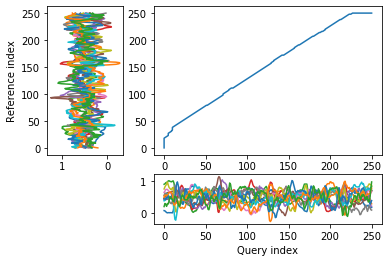

Stretch = 0.07
Distance  = 0.10
Correlation = 0.78


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.61952  1.96813    2.12749  2.73506  2.79482  3.09363  3.24303   
start 2  1.89841  2.24701    2.39641  3.01394  3.08367  3.38247  3.52191   
len 1       0.35     0.16       0.61     0.06     0.30     0.15     0.06   
len 2       0.35     0.15       0.62     0.07     0.30     0.14     0.05   
stretch     0.00     0.05       0.06     0.12     0.09     0.05     0.15   

               8        9  
seg        pause  project  
start 1  3.30279  3.44223  
start 2  3.57171   3.7012  
len 1       0.14     0.35  
len 2       0.13     0.29  
stretch     0.16     0.11

1      2          3      4      5      6     7      8        9
seg      We have  pause  really en  pause  joyed  pause   the  pause  project
stretch     0.00   0.05       0.06   0.12   0.09   0.05  0.15   0.16     0.11

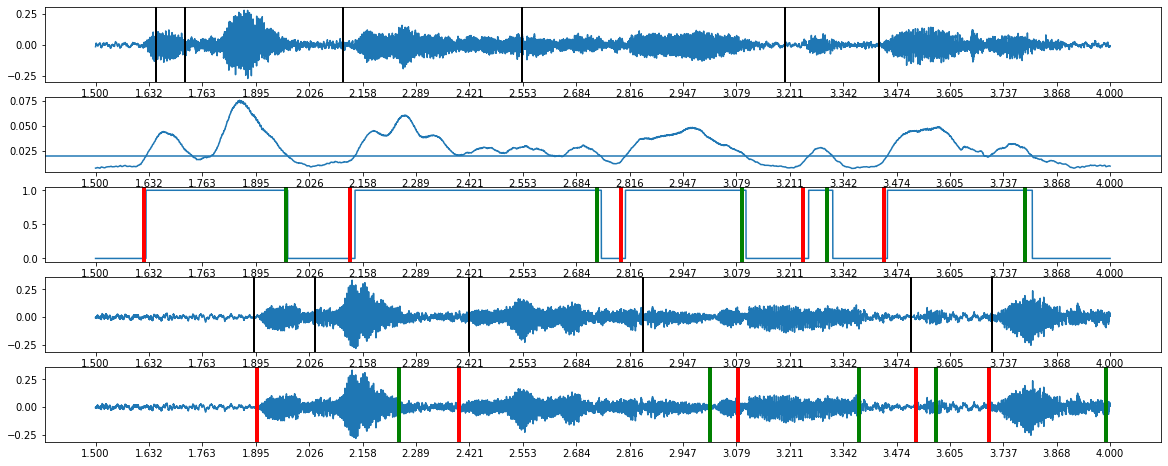

In [30]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-normal2.wav", 1.5, 4

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]
timelst2 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, 
       threshold1=0.02, 
      timelst1=timelst1, timelst2 = timelst2) # unit for input_min_pause = ms

# 8. normal1normal3

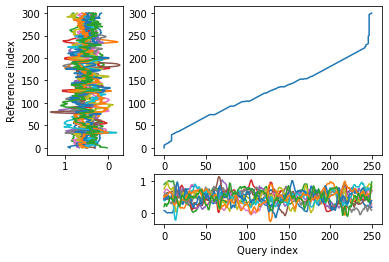

Stretch = 0.12
Distance  = 0.11
Correlation = 0.77


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.61952  1.96813    2.12749  2.73506  2.79482  3.09363  3.24303   
start 2  1.31873  1.65737    1.75697   2.2251   2.2749  2.48406  2.56375   
len 1       0.35     0.16       0.61     0.06     0.30     0.15     0.06   
len 2       0.34     0.10       0.47     0.05     0.21     0.08     0.05   
stretch     0.02     0.32       0.18     0.00     0.24     0.41     0.15   

               8        9  
seg        pause  project  
start 1  3.30279  3.44223  
start 2  2.61355  2.75299  
len 1       0.14     0.35  
len 2       0.14     0.35  
stretch     0.00     0.00

1      2          3      4      5      6     7      8        9
seg      We have  pause  really en  pause  joyed  pause   the  pause  project
stretch     0.02   0.32       0.18   0.00   0.24   0.41  0.15   0.00     0.00

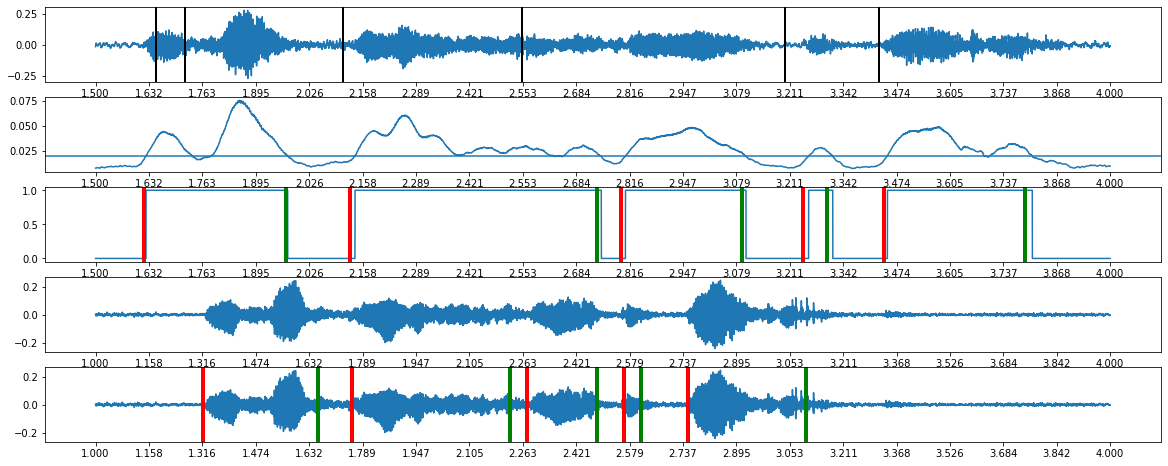

In [31]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-normal3.wav", 1, 4

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, 
       threshold1=0.02, 
      timelst1=timelst1) # unit for input_min_pause = ms 

# 9. normal2normal3

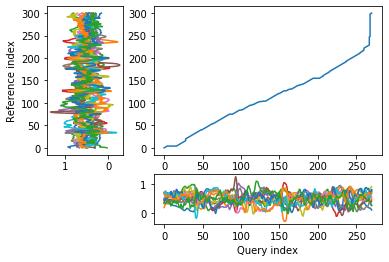

Stretch = 0.14
Distance  = 0.11
Correlation = 0.77


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.89852   2.2572    2.39668  2.96458  3.03432  3.39299  3.54244   
start 2  1.31882  1.65756     1.7572  2.18561  2.24539  2.50443  2.57417   
len 1       0.36     0.14       0.57     0.07     0.36     0.15     0.05   
len 2       0.34     0.10       0.43     0.06     0.26     0.07     0.06   
stretch     0.04     0.24       0.19     0.12     0.22     0.49     0.15   

               8        9  
seg        pause  project  
start 1  3.59225  3.71181  
start 2  2.63395  2.76347  
len 1       0.12     0.39  
len 2       0.13     0.46  
stretch     0.06     0.12

1      2          3      4      5      6     7      8        9
seg      We have  pause  really en  pause  joyed  pause   the  pause  project
stretch     0.04   0.24       0.19   0.12   0.22   0.49  0.15   0.06     0.12

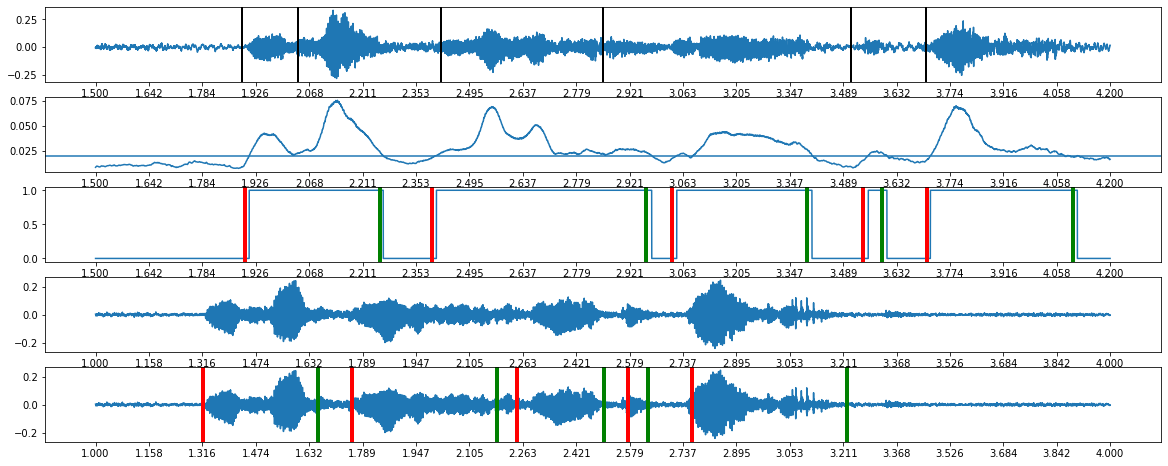

In [32]:
file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 4.2
file2, seg2_1, seg2_2 = "report-normal3.wav", 1, 4

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, 
       threshold1=0.02, timelst1 = timelst1, segments = segments2) # unit for input_min_pause =  ms 

# 2. normal1pause1

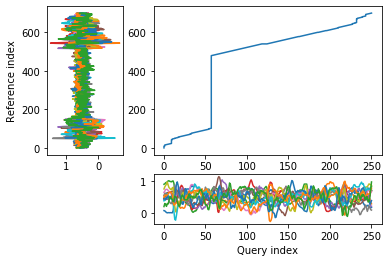

Stretch = 0.87
Distance  = 0.15
Correlation = 0.53


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.61952  1.96813    2.12749  2.73506  2.79482  3.09363  3.24303   
start 2  1.97809  2.39641    6.33068  6.87849  6.93825  7.23705  7.37649   
len 1       0.35     0.16       0.61     0.06     0.30     0.15     0.06   
len 2       0.42     3.93       0.55     0.06     0.30     0.14     0.06   
stretch     0.13     0.95       0.06     0.00     0.00     0.05     0.00   

               8        9  
seg        pause  project  
start 1  3.30279  3.44223  
start 2  7.43625  7.56574  
len 1       0.14     0.35  
len 2       0.13     0.39  
stretch     0.06     0.12

1      2          3      4      5      6     7      8        9
seg      We have  pause  really en  pause  joyed  pause   the  pause  project
stretch     0.13   0.95       0.06   0.00   0.00   0.05  0.00   0.06     0.12

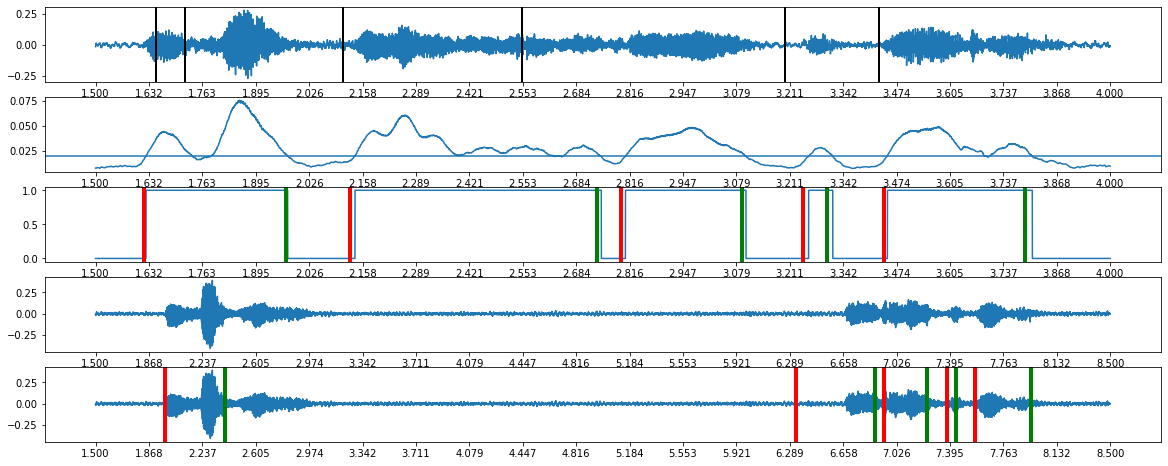

In [33]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-pause1.wav", 1.5, 8.5

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, 
       threshold1 = 0.02, timelst1=timelst1)

# 3. normal1pause2

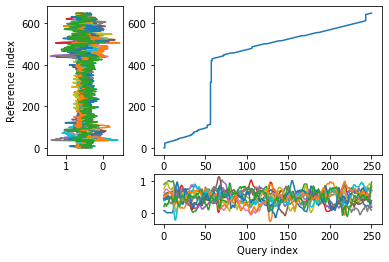

Stretch = 0.85
Distance  = 0.13
Correlation = 0.69


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.61952  1.96813    2.12749  2.73506  2.79482  3.09363  3.24303   
start 2  2.34861  2.91633    6.33267        7  7.05976  7.32869  7.44821   
len 1       0.35     0.16       0.61     0.06     0.30     0.15     0.06   
len 2       0.57     3.42       0.67     0.06     0.27     0.12     0.06   
stretch     0.31     0.94       0.18     0.00     0.08     0.16     0.00   

               8        9  
seg        pause  project  
start 1  3.30279  3.44223  
start 2  7.50797  7.62749  
len 1       0.14     0.35  
len 2       0.12     0.35  
stretch     0.12     0.00

1      2          3      4      5      6     7      8        9
seg      We have  pause  really en  pause  joyed  pause   the  pause  project
stretch     0.31   0.94       0.18   0.00   0.08   0.16  0.00   0.12     0.00

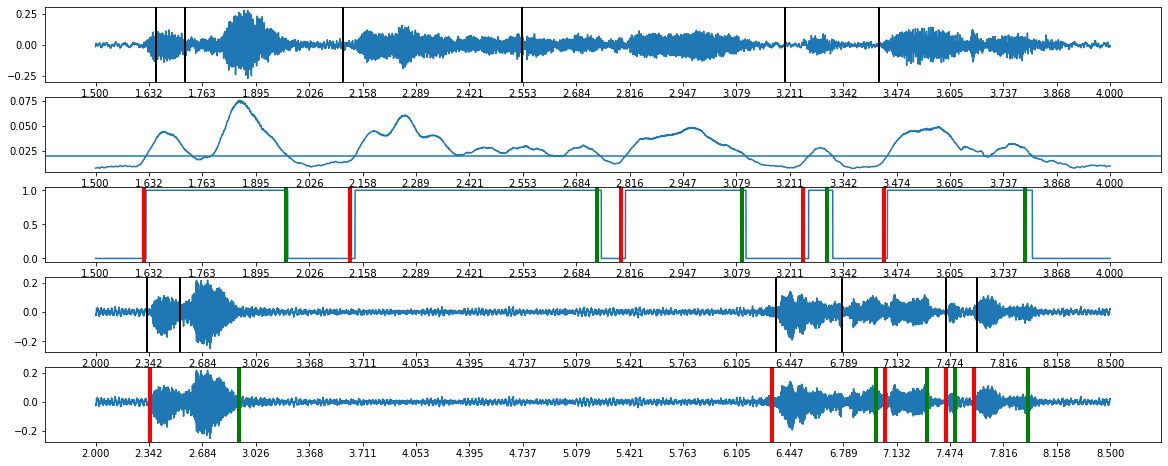

In [34]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-pause2.wav", 2, 8.5

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]
timelst2 = [2.33, 2.54, 6.36, 6.78, 7.45, 7.65]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, 
       threshold1 = 0.02, timelst1=timelst1, timelst2 = timelst2)

# 4. normal1longword1

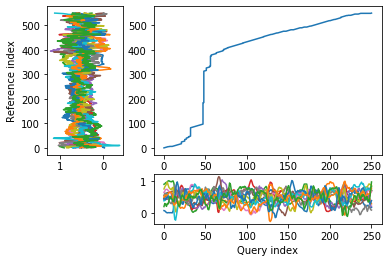

Stretch = 0.85
Distance  = 0.13
Correlation = 0.69


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.61952  1.96813    2.12749  2.73506  2.79482  3.09363  3.24303   
start 2  1.57968  2.46614    5.33466  6.06175  6.11155  6.34064  6.44024   
len 1       0.35     0.16       0.61     0.06     0.30     0.15     0.06   
len 2       0.89     2.87       0.73     0.05     0.23     0.10     0.05   
stretch     0.53     0.93       0.13     0.00     0.18     0.28     0.15   

               8        9  
seg        pause  project  
start 1  3.30279  3.44223  
start 2  6.49004  6.62948  
len 1       0.14     0.35  
len 2       0.14     0.31  
stretch     0.00     0.17

1      2          3      4      5      6     7      8        9
seg      We have  pause  really en  pause  joyed  pause   the  pause  project
stretch     0.53   0.93       0.13   0.00   0.18   0.28  0.15   0.00     0.17

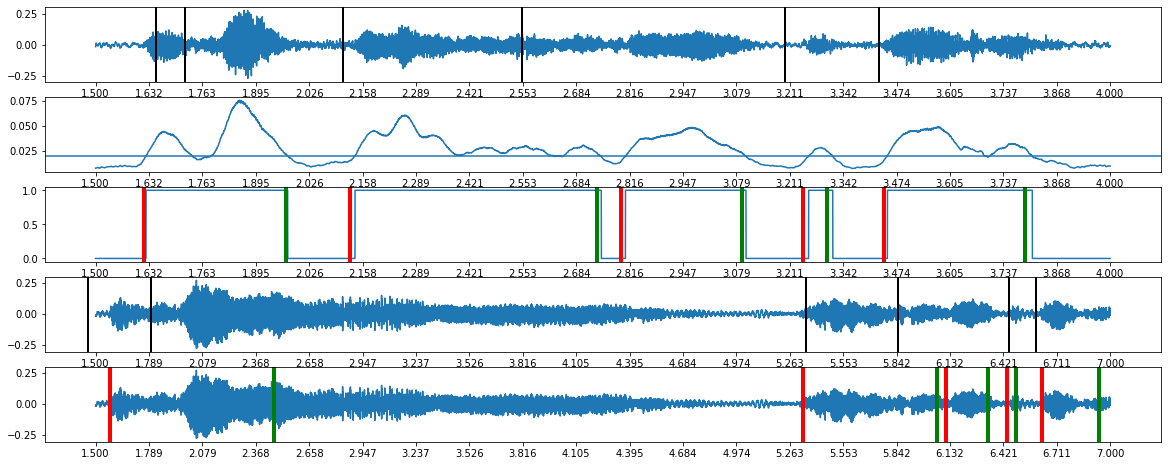

In [35]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-longword1.wav", 1.5, 7

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]
timelst2 = [1.46, 1.80, 5.35, 5.85, 6.45, 6.6]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, 
       threshold1 = 0.02, timelst1=timelst1, timelst2 = timelst2)

# 5. normal1longword2

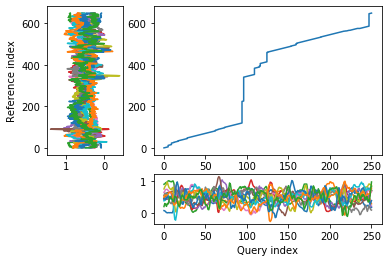

Stretch = 0.70
Distance  = 0.13
Correlation = 0.71


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.61952  1.96813    2.12749  2.73506  2.79482  3.09363  3.24303   
start 2  1.75896  2.16733    2.35657  5.63347  6.15139  6.50996  6.67928   
len 1       0.35     0.16       0.61     0.06     0.30     0.15     0.06   
len 2       0.41     0.19       3.28     0.52     0.36     0.17     0.06   
stretch     0.11     0.13       0.76     0.87     0.13     0.09     0.00   

               8        9  
seg        pause  project  
start 1  3.30279  3.44223  
start 2  6.73904  6.88845  
len 1       0.14     0.35  
len 2       0.15     0.32  
stretch     0.05     0.07

1      2          3      4      5      6     7      8        9
seg      We have  pause  really en  pause  joyed  pause   the  pause  project
stretch     0.11   0.13       0.76   0.87   0.13   0.09  0.00   0.05     0.07

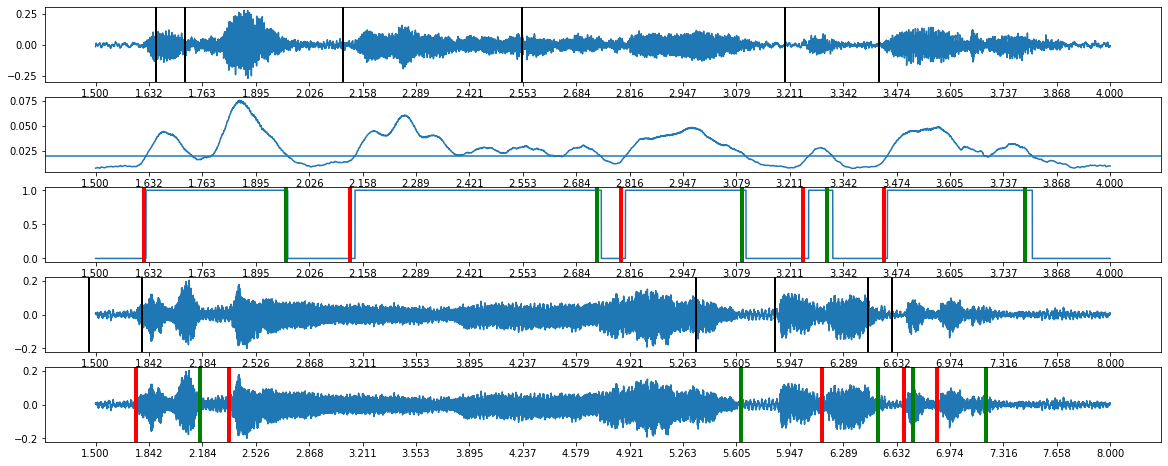

In [36]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-longword2.wav", 1.5, 8

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]
timelst2 = [1.46, 1.80, 5.35, 5.85, 6.45, 6.6]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, 
       threshold1 = 0.02, timelst1=timelst1, timelst2 = timelst2)

# 6. normal1combo1

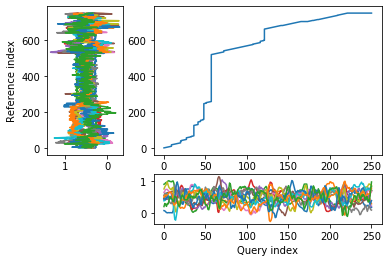

Stretch = 0.81
Distance  = 0.14
Correlation = 0.60


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.61952  1.96813    2.12749  2.73506  2.79482  3.09363  3.24303   
start 2   1.6992  3.05378    6.72908  8.11355  8.17331  8.45219  8.52191   
len 1       0.35     0.16       0.61     0.06     0.30     0.15     0.06   
len 2       1.35     3.68       1.38     0.06     0.28     0.07     0.05   
stretch     0.68     0.94       0.48     0.00     0.05     0.49     0.15   

               8        9  
seg        pause  project  
start 1  3.30279  3.44223  
start 2  8.57171   8.7012  
len 1       0.14     0.35  
len 2       0.13     0.27  
stretch     0.06     0.20

1      2          3      4      5      6     7      8        9
seg      We have  pause  really en  pause  joyed  pause   the  pause  project
stretch     0.68   0.94       0.48   0.00   0.05   0.49  0.15   0.06     0.20

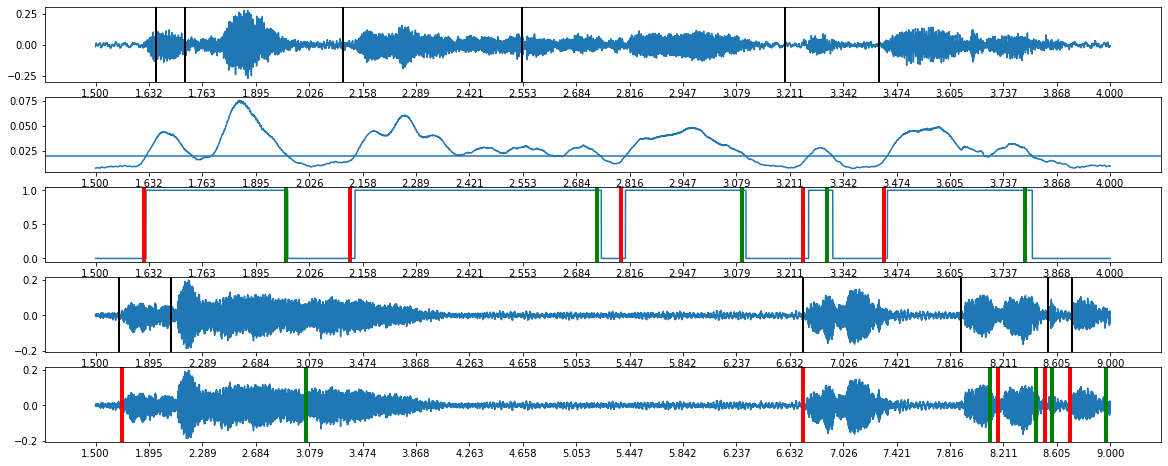

In [37]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-combo1.wav", 1.5, 9

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]
timelst2 = [1.67, 2.06, 6.73, 7.9, 8.54, 8.72]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, 
       threshold1 = 0.02, timelst1=timelst1, timelst2 = timelst2)

# 7. normal1combo2

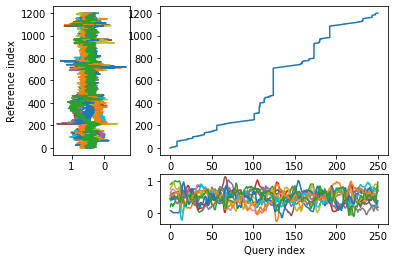

Stretch = 0.75
Distance  = 0.15
Correlation = 0.65


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.61952  1.96813    2.12749  2.73506  2.79482  3.09363  3.24303   
start 2  2.62749  3.40438    4.07171  6.65139  9.13147  9.67928  11.2829   
len 1       0.35     0.16       0.61     0.06     0.30     0.15     0.06   
len 2       0.78     0.67       2.58     2.48     0.55     1.60     0.36   
stretch     0.47     0.71       0.70     0.97     0.38     0.88     0.81   

               8        9  
seg        pause  project  
start 1  3.30279  3.44223  
start 2  11.6414  12.8267  
len 1       0.14     0.35  
len 2       1.19     0.38  
stretch     0.85     0.06

1      2          3      4      5      6     7      8        9
seg      We have  pause  really en  pause  joyed  pause   the  pause  project
stretch     0.47   0.71       0.70   0.97   0.38   0.88  0.81   0.85     0.06

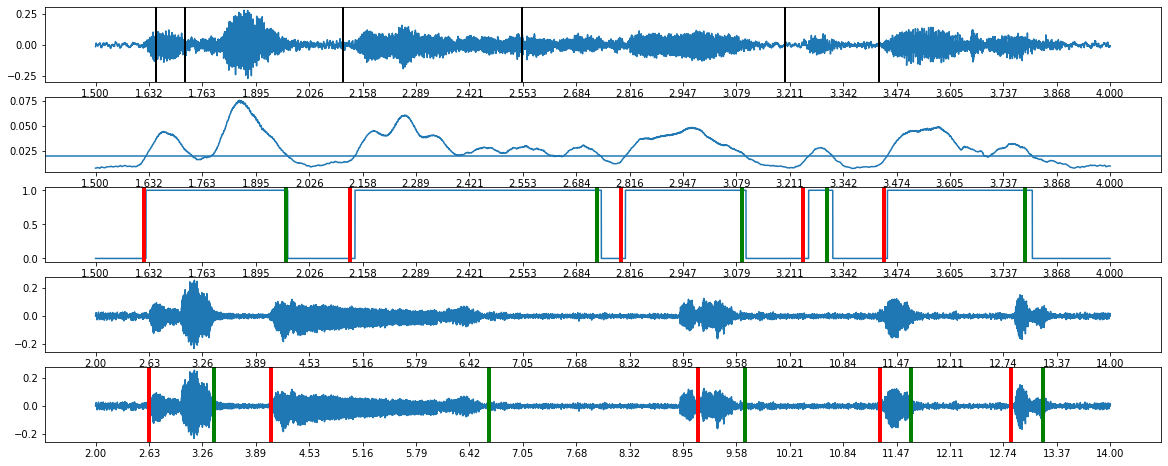

In [38]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-combo2.wav", 2, 14

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, 
       threshold1 = 0.02, timelst1=timelst1)

# 10. normal2pause1

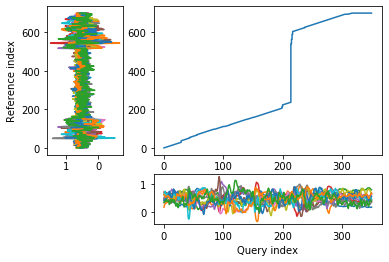

Stretch = 0.90
Distance  = 0.14
Correlation = 0.49


1        2          3        4        5        6        7   \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.89886  2.25783    2.39744  2.96581  3.03561  3.39459  3.54416   
start 2  1.97863  2.38746    2.50712  3.04558  3.10541  3.46439   3.7735   
len 1       0.36     0.14       0.57     0.07     0.36     0.15     0.05   
len 2       0.41     0.12       0.54     0.06     0.36     0.31     0.05   
stretch     0.09     0.11       0.06     0.12     0.00     0.45     0.00   

              8        9        10       11  
seg        pause   projec    pause        t  
start 1  3.59402  3.71368  4.10256  4.19231  
start 2  3.82336  7.57265  7.98148  8.07123  
len 1       0.12     0.39     0.09     0.10  
len 2       3.75     0.41     0.09     0.10  
stretch     0.96     0.04     0.00     0.00

1      2          3      4      5      6     7      8       9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  projec   
stretch     0.09   0.11       0.06   0.12   0.00   0.45  0.00   0.96    0.04   

            10    11  
seg      pause     t  
stretch   0.00  0.00

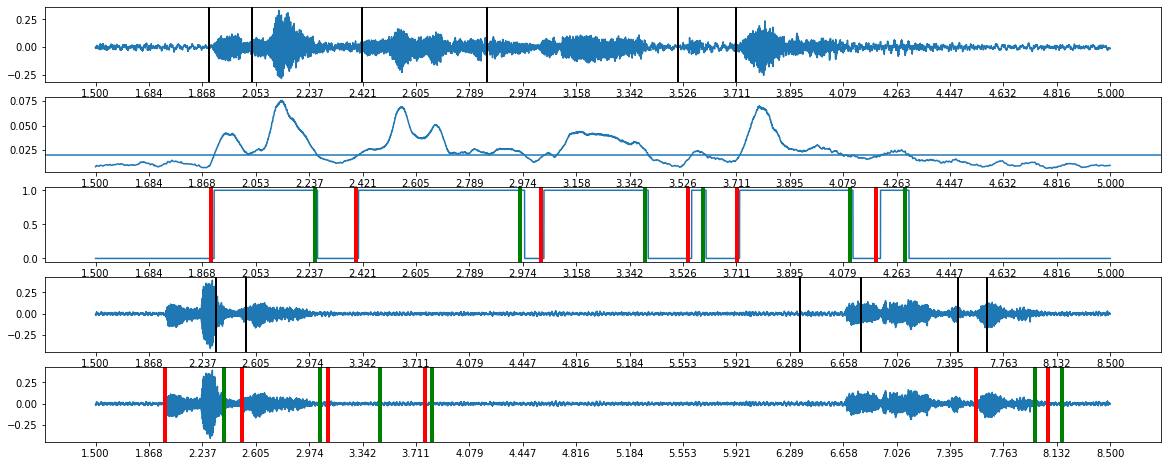

In [42]:
file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 5
file2, seg2_1, seg2_2 = "report-pause1.wav", 1.5, 8.5

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]
timelst2 = [2.33, 2.54, 6.36, 6.78, 7.45, 7.65]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.02,
      timelst1=timelst1, timelst2 = timelst2, segments = segmentsnormal2)

# 11. normal2pause2

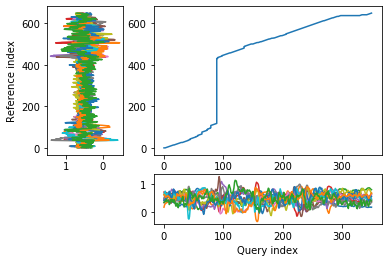

Stretch = 0.81
Distance  = 0.12
Correlation = 0.73


1        2          3        4        5        6        7   \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.89886  2.25783    2.39744  2.96581  3.03561  3.39459  3.54416   
start 2    2.349  2.92735    6.29772  6.99573  7.03561  7.32479  7.45442   
len 1       0.36     0.14       0.57     0.07     0.36     0.15     0.05   
len 2       0.58     3.37       0.70     0.04     0.29     0.13     0.07   
stretch     0.31     0.95       0.16     0.41     0.15     0.11     0.26   

              8        9        10       11  
seg        pause   projec    pause        t  
start 1  3.59402  3.71368  4.10256  4.19231  
start 2  7.52422  7.64387  8.03276  8.11254  
len 1       0.12     0.39     0.09     0.10  
len 2       0.12     0.39     0.08     0.10  
stretch     0.00     0.00     0.00     0.00

1      2          3      4      5      6     7      8       9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  projec   
stretch     0.31   0.95       0.16   0.41   0.15   0.11  0.26   0.00    0.00   

            10    11  
seg      pause     t  
stretch   0.00  0.00

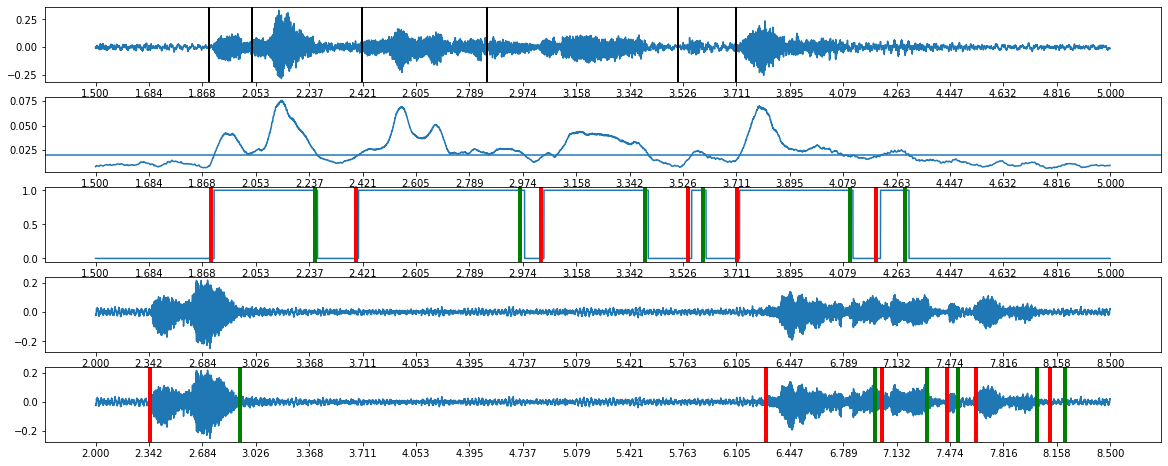

In [43]:
file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 5
file2, seg2_1, seg2_2 = "report-pause2.wav", 2, 8.5

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.02,
      timelst1=timelst1, segments = segmentsnormal2)

# 12. normal2longword1

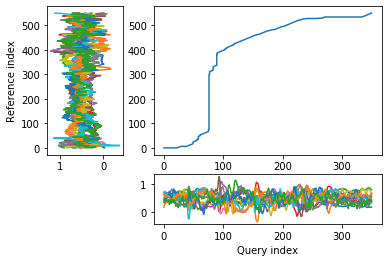

Stretch = 0.88
Distance  = 0.15
Correlation = 0.56


1        2          3        4        5        6        7   \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.89886  2.25783    2.39744  2.96581  3.03561  3.39459  3.54416   
start 2  1.57977  2.24786    5.31909  6.01709  6.08689  6.34615  6.47578   
len 1       0.36     0.14       0.57     0.07     0.36     0.15     0.05   
len 2       0.67     3.07       0.70     0.07     0.26     0.13     0.05   
stretch     0.39     0.94       0.14     0.00     0.22     0.11     0.00   

              8        9        10       11  
seg        pause   projec    pause        t  
start 1  3.59402  3.71368  4.10256  4.19231  
start 2  6.52564   6.6453  6.77493  6.81481  
len 1       0.12     0.39     0.09     0.10  
len 2       0.12     0.13     0.04     0.01  
stretch     0.00     0.58     0.54     0.85

1      2          3      4      5      6     7      8       9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  projec   
stretch     0.39   0.94       0.14   0.00   0.22   0.11  0.00   0.00    0.58   

            10    11  
seg      pause     t  
stretch   0.54  0.85

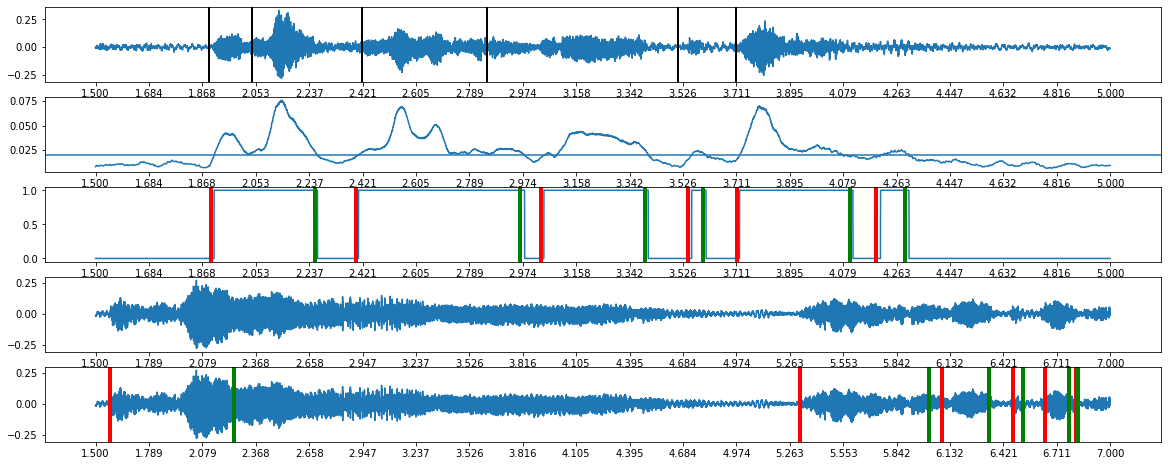

In [44]:
file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 5
file2, seg2_1, seg2_2 = "report-longword1.wav", 1.5, 7

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.02,
      timelst1=timelst1, segments = segmentsnormal2)

# 13. normal2longword2

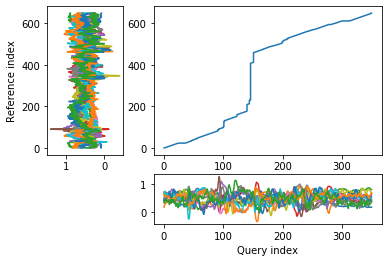

Stretch = 0.62
Distance  = 0.14
Correlation = 0.67


1        2          3        4        5        6        7   \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.89886  2.25783    2.39744  2.96581  3.03561  3.39459  3.54416   
start 2  1.76923  2.16809    2.30769  5.57835  6.10684  6.45584  6.69516   
len 1       0.36     0.14       0.57     0.07     0.36     0.15     0.05   
len 2       0.40     0.14       3.27     0.53     0.35     0.24     0.09   
stretch     0.08     0.00       0.77     0.84     0.06     0.37     0.41   

              8        9        10       11  
seg        pause   projec    pause        t  
start 1  3.59402  3.71368  4.10256  4.19231  
start 2   6.7849  6.90456  7.26353  7.35328  
len 1       0.12     0.39     0.09     0.10  
len 2       0.12     0.36     0.09     0.08  
stretch     0.00     0.06     0.00     0.08

1      2          3      4      5      6     7      8       9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  projec   
stretch     0.08   0.00       0.77   0.84   0.06   0.37  0.41   0.00    0.06   

            10    11  
seg      pause     t  
stretch   0.00  0.08

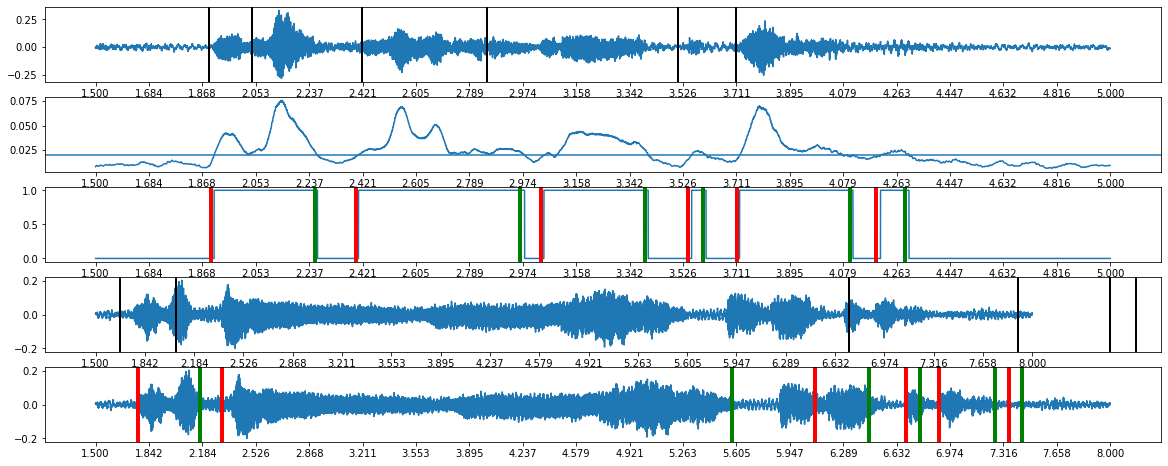

In [45]:
file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 5
file2, seg2_1, seg2_2 = "report-longword2.wav", 1.5, 8

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]
timelst2 = [1.67, 2.06, 6.73, 7.9, 8.54, 8.72]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.02,
      timelst1=timelst1, timelst2 = timelst2, segments = segmentsnormal2)

# 14. normal2combo1

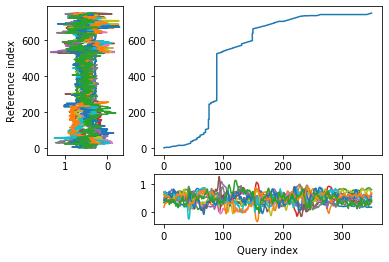

Stretch = 0.83
Distance  = 0.15
Correlation = 0.54


1        2          3        4        5        6        7   \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.89886  2.25783    2.39744  2.96581  3.03561  3.39459  3.54416   
start 2   1.7094  3.08547    6.73504  7.43305  8.14103  8.48006  8.54986   
len 1       0.36     0.14       0.57     0.07     0.36     0.15     0.05   
len 2       1.38     3.65       0.70     0.71     0.34     0.07     0.05   
stretch     0.67     0.95       0.14     0.88     0.08     0.49     0.00   

              8        9        10       11  
seg        pause   projec    pause        t  
start 1  3.59402  3.71368  4.10256  4.19231  
start 2  8.59972  8.71937  8.86895  8.89886  
len 1       0.12     0.39     0.09     0.10  
len 2       0.12     0.15     0.03     0.00  
stretch     0.00     0.55     0.54     1.00

1      2          3      4      5      6     7      8       9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  projec   
stretch     0.67   0.95       0.14   0.88   0.08   0.49  0.00   0.00    0.55   

            10    11  
seg      pause     t  
stretch   0.54  1.00

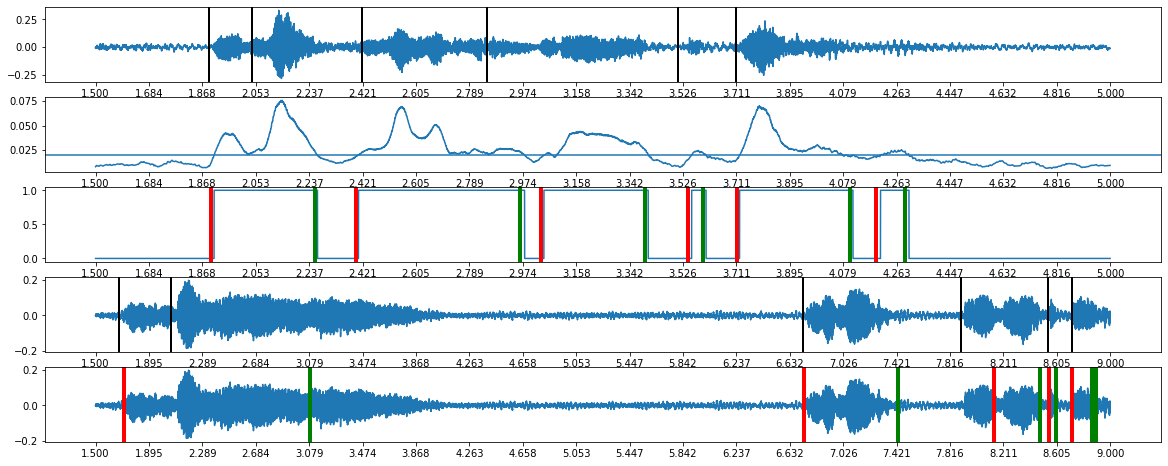

In [46]:
file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 5
file2, seg2_1, seg2_2 = "report-combo1.wav", 1.5, 9

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.02,
      timelst1=timelst1, timelst2 = timelst2, segments = segmentsnormal2)

# 15. normal2combo2

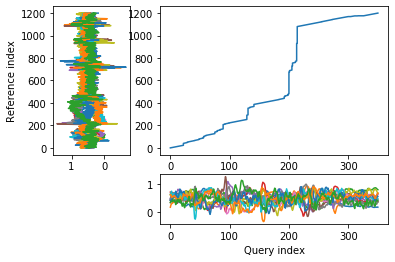

Stretch = 0.83
Distance  = 0.14
Correlation = 0.61


1        2          3        4        5        6        7   \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.89886  2.25783    2.39744  2.96581  3.03561  3.39459  3.54416   
start 2  2.62821  3.40598    4.07407   5.9188   5.9886  6.36752  8.90028   
len 1       0.36     0.14       0.57     0.07     0.36     0.15     0.05   
len 2       0.78     0.67       1.84     0.07     0.38     2.53     0.67   
stretch     0.46     0.74       0.62     0.00     0.04     0.92     0.92   

              8        9        10       11  
seg        pause   projec    pause        t  
start 1  3.59402  3.71368  4.10256  4.19231  
start 2  9.56838   12.849  13.2578  13.3476  
len 1       0.12     0.39     0.09     0.10  
len 2       3.28     0.41     0.09     0.12  
stretch     0.95     0.07     0.00     0.14

1      2          3      4      5      6     7      8       9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  projec   
stretch     0.46   0.74       0.62   0.00   0.04   0.92  0.92   0.95    0.07   

            10    11  
seg      pause     t  
stretch   0.00  0.14

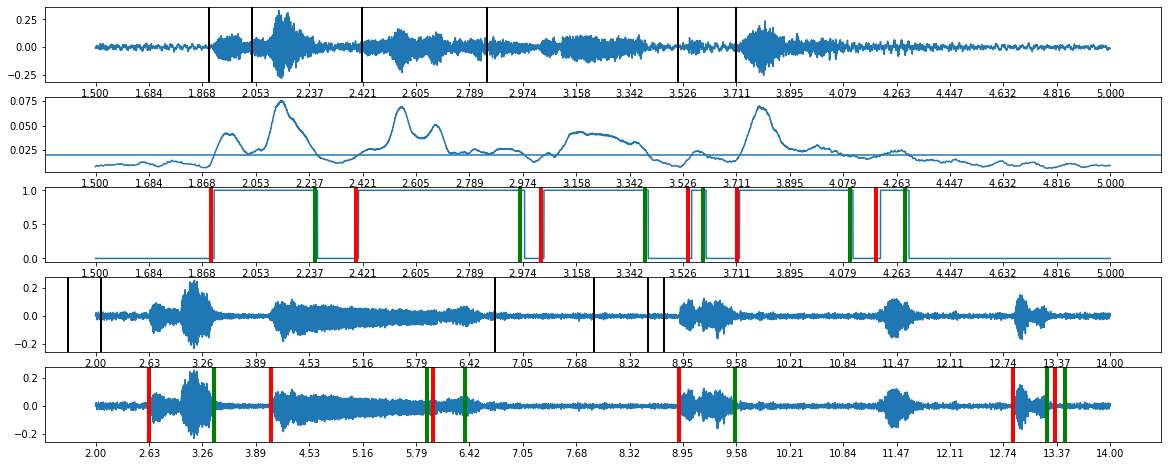

In [47]:
file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 5
file2, seg2_1, seg2_2 = "report-combo2.wav", 2, 14

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.02,
      timelst1=timelst1, timelst2 = timelst2, segments = segmentsnormal2)

# 16. normal3pause1

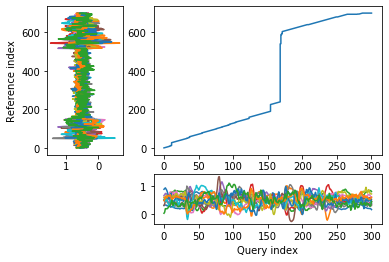

Stretch = 0.90
Distance  = 0.14
Correlation = 0.52


1        2        3        4          5        6        7   \
seg           We    pause     have    pause  really en    pause    joyed   
start 1   1.3289  1.42857  1.50831  1.62791    1.76744  2.22591  2.28571   
start 2  1.98837  2.13787  2.21761  2.35714    2.50664  3.02492  3.14452   
len 1       0.10     0.08     0.12     0.14       0.46     0.06     0.19   
len 2       0.15     0.08     0.14     0.15       0.52     0.12     0.19   
stretch     0.28     0.00     0.11     0.05       0.09     0.46     0.00   

              8        9        10       11       12       13  
seg        pause      the    pause      pro    pause     ject  
start 1  2.47508  2.56478  2.59468  2.74419  2.92359  3.02326  
start 2  3.33389  3.77243  3.80233   7.5598   7.7392  7.83887  
len 1       0.09     0.03     0.15     0.18     0.10     0.04  
len 2       0.44     0.03     3.76     0.18     0.10     0.04  
stretch     0.76     0.00     0.95     0.00     0.00     0.00

1      2     3      4          5      6      7      8     9   \
seg        We  pause  have  pause  really en  pause  joyed  pause   the   
stretch  0.28   0.00  0.11   0.05       0.09   0.46   0.00   0.76  0.00   

            10    11     12    13  
seg      pause   pro  pause  ject  
stretch   0.95  0.00   0.00  0.00

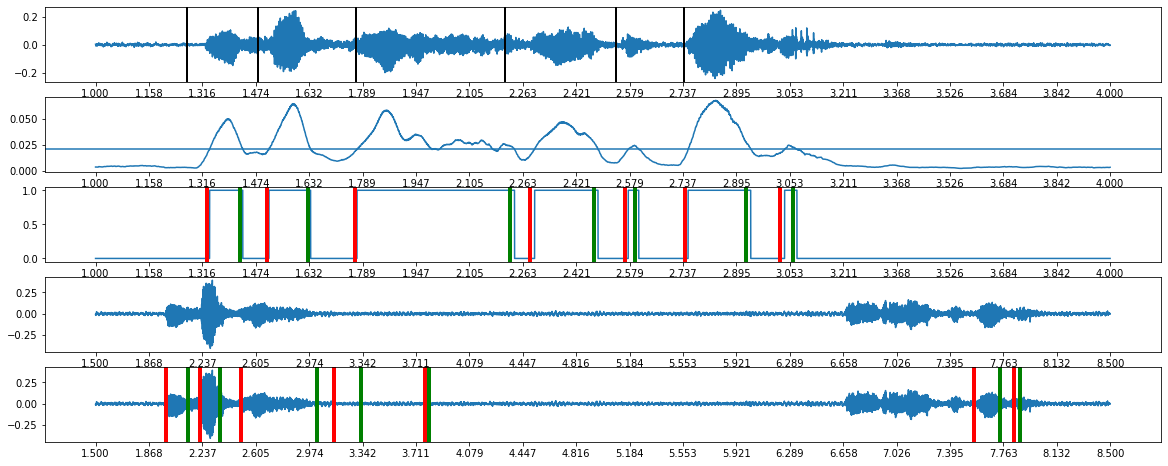

In [63]:
file1, seg1_1, seg1_2 = "report-normal3.wav", 1, 4
file2, seg2_1, seg2_2 = "report-pause1.wav", 1.5, 8.5

timelst1 = [1.27, 1.48, 1.77, 2.21, 2.54, 2.74]
output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.021,
      timelst1=timelst1, segments = segmentsnormal3)

# 17. normal3pause2

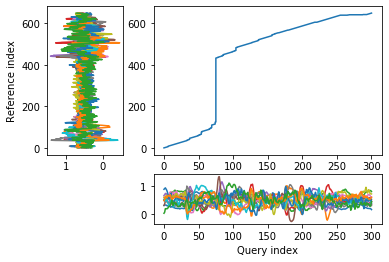

Stretch = 0.87
Distance  = 0.14
Correlation = 0.67


1        2        3        4          5        6        7   \
seg           We    pause     have    pause  really en    pause    joyed   
start 1   1.3289  1.42857  1.50831  1.62791    1.76744  2.22591  2.28571   
start 2  2.34884  2.51827  2.61794  2.86711    6.33555  7.01329  7.08306   
len 1       0.10     0.08     0.12     0.14       0.46     0.06     0.19   
len 2       0.17     0.10     0.25     3.47       0.68     0.07     0.23   
stretch     0.36     0.17     0.46     0.95       0.26     0.12     0.14   

              8        9        10       11       12       13  
seg        pause      the    pause      pro    pause     ject  
start 1  2.47508  2.56478  2.59468  2.74419  2.92359  3.02326  
start 2  7.31229  7.44186  7.47176  7.62126   7.7907  7.89037  
len 1       0.09     0.03     0.15     0.18     0.10     0.04  
len 2       0.13     0.03     0.15     0.17     0.10     0.04  
stretch     0.26     0.00     0.10     0.04     0.00     0.00

1      2     3      4          5      6      7      8     9   \
seg        We  pause  have  pause  really en  pause  joyed  pause   the   
stretch  0.36   0.17  0.46   0.95       0.26   0.12   0.14   0.26  0.00   

            10    11     12    13  
seg      pause   pro  pause  ject  
stretch   0.10  0.04   0.00  0.00

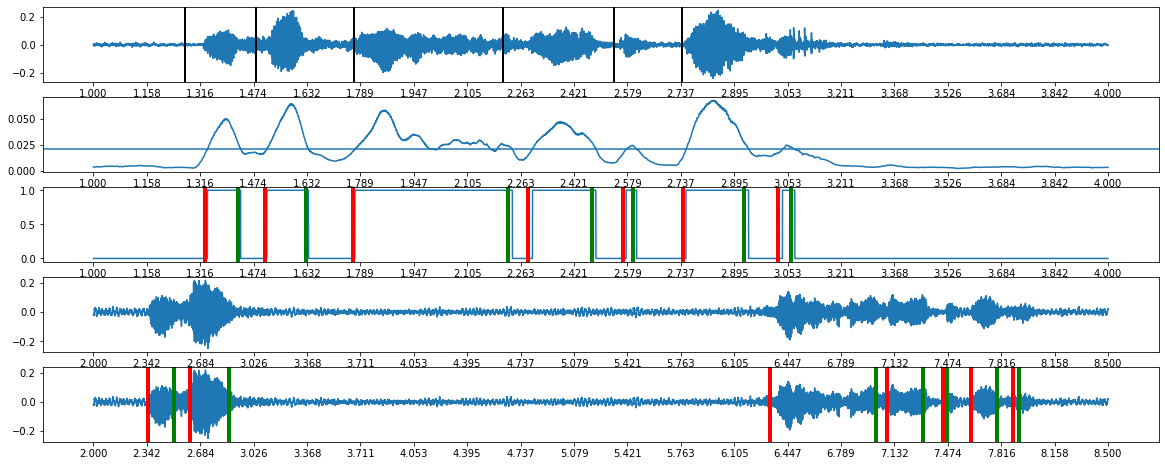

In [64]:
file1, seg1_1, seg1_2 = "report-normal3.wav", 1, 4
file2, seg2_1, seg2_2 = "report-pause2.wav", 2, 8.5

timelst1 = [1.27, 1.48, 1.77, 2.21, 2.54, 2.74]
output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.021,
      timelst1=timelst1, segments = segmentsnormal3)

# 18. normal3longword1

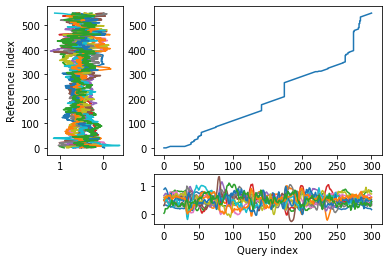

Stretch = 0.36
Distance  = 0.17
Correlation = 0.34


1        2        3        4          5        6        7   \
seg          We    pause     have    pause  really en    pause    joyed   
start 1  1.3289  1.42857  1.50831  1.62791    1.76744  2.22591  2.28571   
start 2  1.5897  1.75914  1.97841  2.21761    2.37708  2.83555  2.89535   
len 1      0.10     0.08     0.12     0.14       0.46     0.06     0.19   
len 2      0.17     0.22     0.24     0.16       0.46     0.06     0.43   
stretch    0.36     0.59     0.44     0.10       0.00     0.00     0.49   

              8        9        10       11       12       13  
seg        pause      the    pause      pro    pause     ject  
start 1  2.47508  2.56478  2.59468  2.74419  2.92359  3.02326  
start 2  3.32392  3.41362  3.44352  4.16113  4.34053   4.4402  
len 1       0.09     0.03     0.15     0.18     0.10     0.04  
len 2       0.09     0.03     0.72     0.18     0.10     0.04  
stretch     0.00     0.00     0.74     0.00     0.00     0.00

1      2     3      4          5      6      7      8     9   \
seg        We  pause  have  pause  really en  pause  joyed  pause   the   
stretch  0.36   0.59  0.44   0.10       0.00   0.00   0.49   0.00  0.00   

            10    11     12    13  
seg      pause   pro  pause  ject  
stretch   0.74  0.00   0.00  0.00

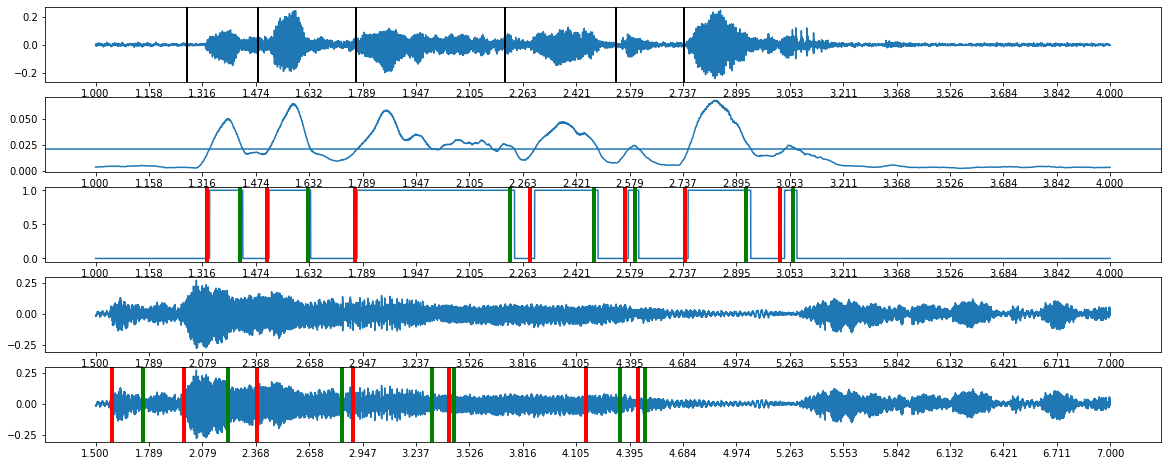

In [65]:
file1, seg1_1, seg1_2 = "report-normal3.wav", 1, 4
file2, seg2_1, seg2_2 = "report-longword1.wav", 1.5, 7

timelst1 = [1.27, 1.48, 1.77, 2.21, 2.54, 2.74]
output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.021,
      timelst1=timelst1, segments = segmentsnormal3)

# 19. normal3longword2

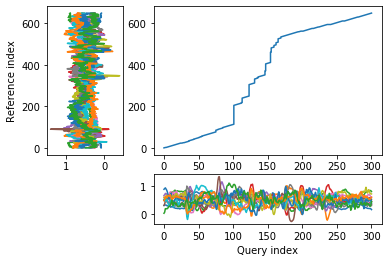

Stretch = 0.66
Distance  = 0.14
Correlation = 0.66


1        2        3        4          5        6        7   \
seg           We    pause     have    pause  really en    pause    joyed   
start 1   1.3289  1.42857  1.50831  1.62791    1.76744  2.22591  2.28571   
start 2  1.78904  1.90864  1.99834  2.14784    2.36711  3.99169  4.59967   
len 1       0.10     0.08     0.12     0.14       0.46     0.06     0.19   
len 2       0.12     0.09     0.15     0.22       1.62     0.61     0.95   
stretch     0.14     0.09     0.16     0.30       0.65     0.89     0.75   

              8        9        10       11       12       13  
seg        pause      the    pause      pro    pause     ject  
start 1  2.47508  2.56478  2.59468  2.74419  2.92359  3.02326  
start 2  5.54651  6.32392  6.43355  6.89203  7.07143  7.13123  
len 1       0.09     0.03     0.15     0.18     0.10     0.04  
len 2       0.78     0.11     0.46     0.18     0.06     0.04  
stretch     0.86     0.74     0.61     0.00     0.36     0.00

1      2     3      4          5      6      7      8     9   \
seg        We  pause  have  pause  really en  pause  joyed  pause   the   
stretch  0.14   0.09  0.16   0.30       0.65   0.89   0.75   0.86  0.74   

            10    11     12    13  
seg      pause   pro  pause  ject  
stretch   0.61  0.00   0.36  0.00

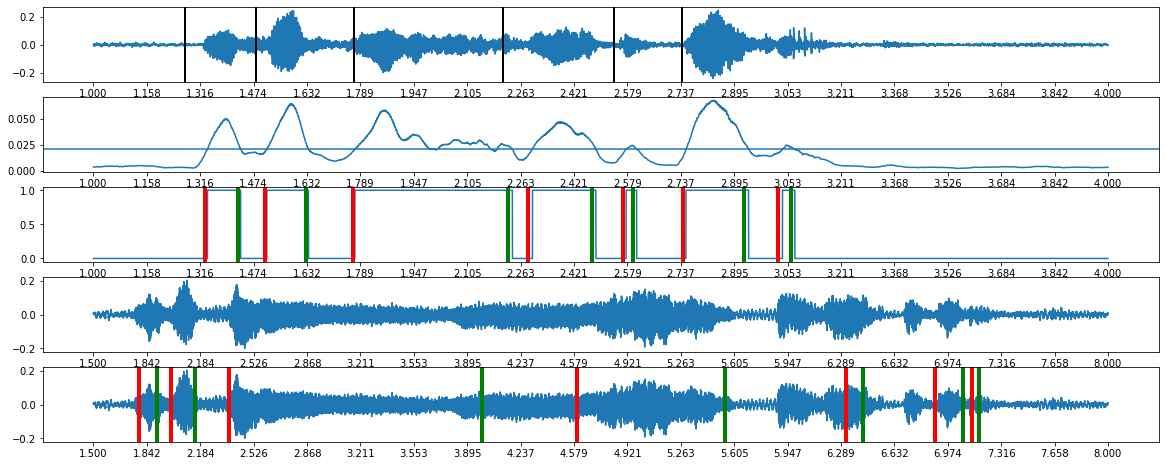

In [66]:
file1, seg1_1, seg1_2 = "report-normal3.wav", 1, 4
file2, seg2_1, seg2_2 = "report-longword2.wav", 1.5, 8

timelst1 = [1.27, 1.48, 1.77, 2.21, 2.54, 2.74]
output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.021,
      timelst1=timelst1, segments = segmentsnormal3)

# 20. normal3combo1

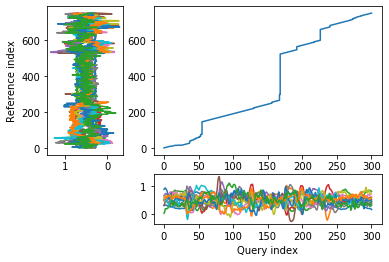

Stretch = 0.86
Distance  = 0.17
Correlation = 0.26


1        2        3        4          5        6        7   \
seg           We    pause     have    pause  really en    pause    joyed   
start 1   1.3289  1.42857  1.50831  1.62791    1.76744  2.22591  2.28571   
start 2  1.71927   1.9485  2.09801  3.02492    3.16445  3.62292  3.68272   
len 1       0.10     0.08     0.12     0.14       0.46     0.06     0.19   
len 2       0.23     0.15     0.93     0.14       0.46     0.06     0.22   
stretch     0.51     0.41     0.84     0.00       0.00     0.00     0.11   

              8        9        10       11       12       13  
seg        pause      the    pause      pro    pause     ject  
start 1  2.47508  2.56478  2.59468  2.74419  2.92359  3.02326  
start 2  3.90199  4.04153  4.07143  6.77243  7.12126  7.22093  
len 1       0.09     0.03     0.15     0.18     0.10     0.04  
len 2       0.14     0.03     2.70     0.35     0.10     0.04  
stretch     0.31     0.00     0.93     0.41     0.00     0.00

1      2     3      4          5      6      7      8     9   \
seg        We  pause  have  pause  really en  pause  joyed  pause   the   
stretch  0.51   0.41  0.84   0.00       0.00   0.00   0.11   0.31  0.00   

            10    11     12    13  
seg      pause   pro  pause  ject  
stretch   0.93  0.41   0.00  0.00

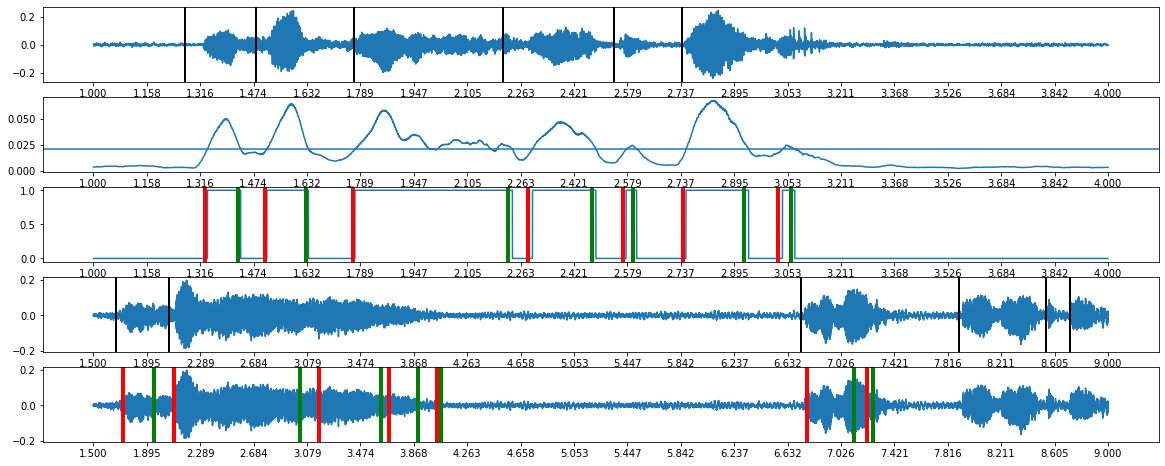

In [67]:
file1, seg1_1, seg1_2 = "report-normal3.wav", 1, 4
file2, seg2_1, seg2_2 = "report-combo1.wav", 1.5, 9

timelst1 = [1.27, 1.48, 1.77, 2.21, 2.54, 2.74]
timelst2 = [1.67, 2.06, 6.73, 7.9, 8.54, 8.72]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.021,
      timelst1=timelst1, timelst2 = timelst2, segments = segmentsnormal3)

# 21. normal3combo2

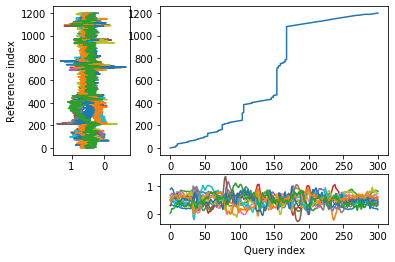

Stretch = 0.87
Distance  = 0.14
Correlation = 0.63


1        2        3        4          5        6        7   \
seg           We    pause     have    pause  really en    pause    joyed   
start 1   1.3289  1.42857  1.50831  1.62791    1.76744  2.22591  2.28571   
start 2  2.64784  2.81728  3.00664  3.37542    4.08306  6.07641  6.13621   
len 1       0.10     0.08     0.12     0.14       0.46     0.06     0.19   
len 2       0.17     0.19     0.37     0.71       1.99     0.06     0.35   
stretch     0.36     0.53     0.62     0.76       0.71     0.00     0.39   

              8        9        10       11       12       13  
seg        pause      the    pause      pro    pause     ject  
start 1  2.47508  2.56478  2.59468  2.74419  2.92359  3.02326  
start 2  6.48505  9.26578  9.48505  12.8339  13.0033   13.103  
len 1       0.09     0.03     0.15     0.18     0.10     0.04  
len 2       2.78     0.22     3.35     0.17     0.10     0.04  
stretch     0.96     0.87     0.94     0.04     0.00     0.00

1      2     3      4          5      6      7      8     9   \
seg        We  pause  have  pause  really en  pause  joyed  pause   the   
stretch  0.36   0.53  0.62   0.76       0.71   0.00   0.39   0.96  0.87   

            10    11     12    13  
seg      pause   pro  pause  ject  
stretch   0.94  0.04   0.00  0.00

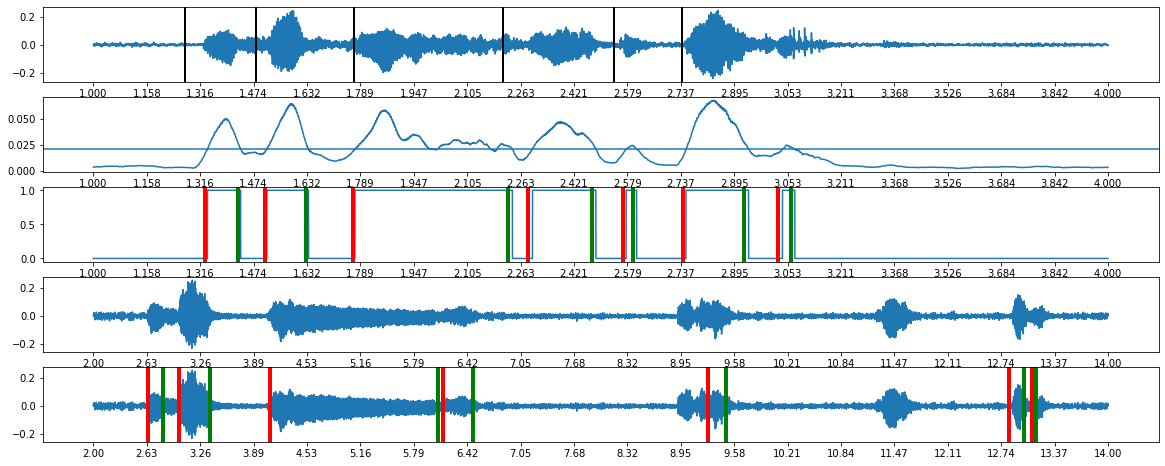

In [68]:
file1, seg1_1, seg1_2 = "report-normal3.wav", 1, 4
file2, seg2_1, seg2_2 = "report-combo2.wav", 2, 14

timelst1 = [1.27, 1.48, 1.77, 2.21, 2.54, 2.74]
output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.021,
      timelst1=timelst1, segments = segmentsnormal3)

# 22. pause1pause2

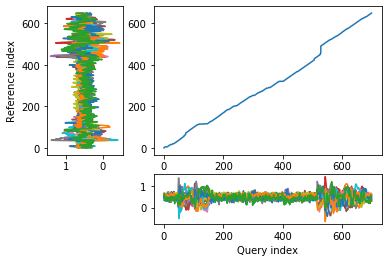

Stretch = 0.16
Distance  = 0.11
Correlation = 0.66


1        2        3        4        5        6        7   \
seg      We have    pause   really    pause  enjoyed    pause      the   
start 1  1.97932  2.39872  2.48859  2.90799  6.66262  7.25178  7.39158   
start 2   2.3495  2.88873   2.9786  3.15835  6.39372  7.33238  7.45221   
len 1       0.42     0.09     0.42     3.75     0.59     0.14     0.06   
len 2       0.54     0.09     0.18     3.24     0.94     0.12     0.06   
stretch     0.17     0.00     0.47     0.13     0.36     0.11     0.00   

              8        9        10       11  
seg        pause      pro    pause     ject  
start 1   7.4515  7.57133  7.75107  7.85093  
start 2  7.51213  7.64194  7.80171  7.90157  
len 1       0.12     0.18     0.10     0.06  
len 2       0.13     0.16     0.10     0.06  
stretch     0.06     0.09     0.00     0.00

1      2       3      4        5      6     7      8     9   \
seg      We have  pause  really  pause  enjoyed  pause   the  pause   pro   
stretch     0.17   0.00    0.47   0.13     0.36   0.11  0.00   0.06  0.09   

            10    11  
seg      pause  ject  
stretch   0.00  0.00

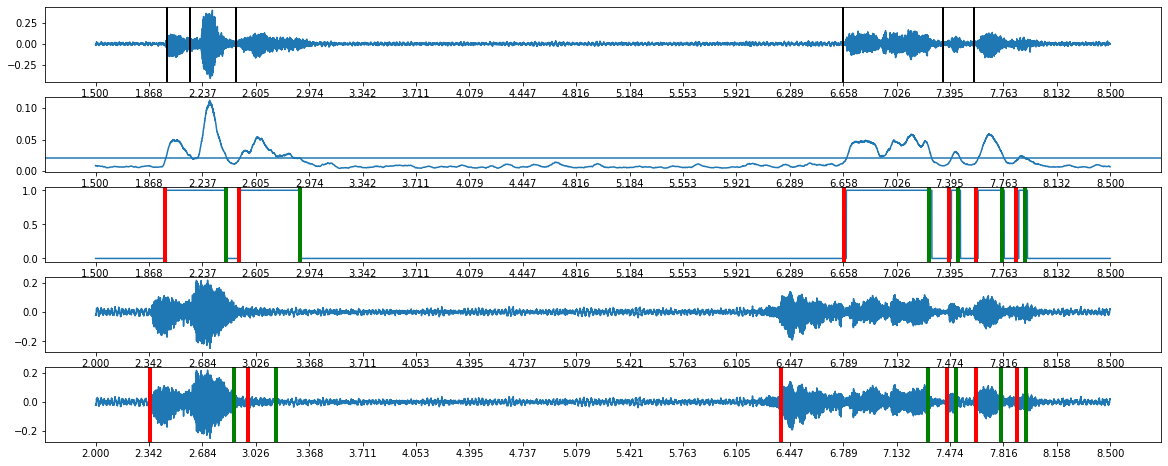

In [69]:
file1, seg1_1, seg1_2 = "report-pause1.wav", 1.5, 8.5
file2, seg2_1, seg2_2 = "report-pause2.wav", 2, 8.5

timelst1 = [1.99, 2.15, 2.47, 6.66, 7.35, 7.56]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.02,
      timelst1=timelst1, segments = segmentspause1)

# 23. pause1longword1

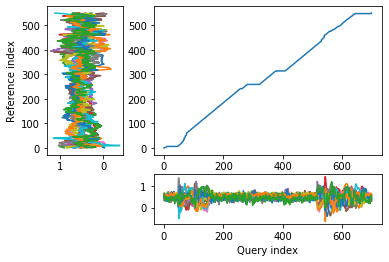

Stretch = 0.16
Distance  = 0.16
Correlation = 0.42


1        2        3        4        5        6        7   \
seg      We have    pause   really    pause  enjoyed    pause      the   
start 1  1.97932  2.39872  2.48859  2.90799  6.66262  7.25178  7.39158   
start 2  1.57989  2.23894  2.32882  2.74822  5.71398  6.34308  6.45292   
len 1       0.42     0.09     0.42     3.75     0.59     0.14     0.06   
len 2       0.66     0.09     0.42     2.97     0.63     0.11     0.05   
stretch     0.29     0.00     0.00     0.16     0.24     0.11     0.15   

              8        9        10       11  
seg        pause      pro    pause     ject  
start 1   7.4515  7.57133  7.75107  7.85093  
start 2  6.50285  6.63267  6.80243   6.8923  
len 1       0.12     0.18     0.10     0.06  
len 2       0.13     0.17     0.09     0.06  
stretch     0.06     0.04     0.08     0.00

1      2       3      4        5      6     7      8     9   \
seg      We have  pause  really  pause  enjoyed  pause   the  pause   pro   
stretch     0.29   0.00    0.00   0.16     0.24   0.11  0.15   0.06  0.04   

            10    11  
seg      pause  ject  
stretch   0.08  0.00

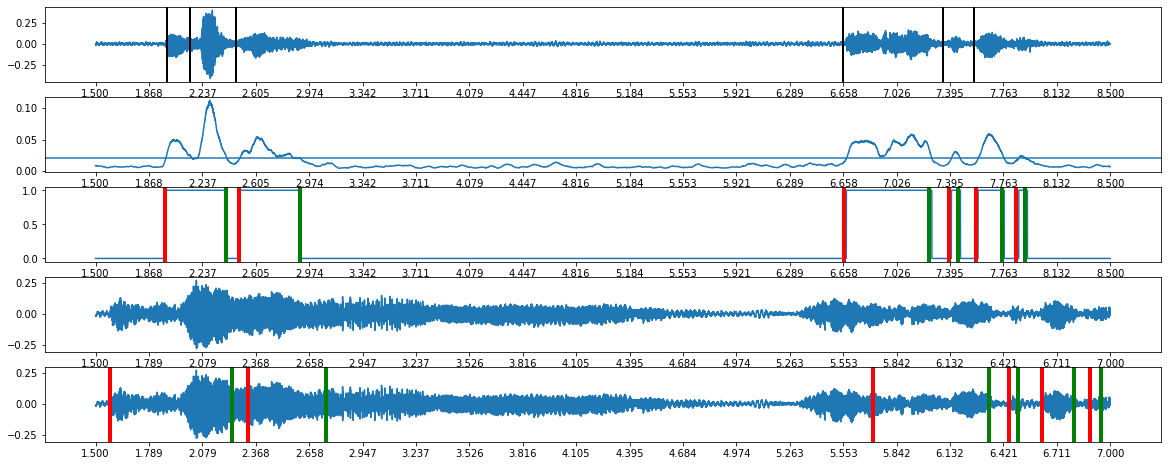

In [70]:
file1, seg1_1, seg1_2 = "report-pause1.wav", 1.5, 8.5
file2, seg2_1, seg2_2 = "report-longword1.wav", 1.5, 7

timelst1 = [1.99, 2.15, 2.47, 6.66, 7.35, 7.56]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.02,
      timelst1=timelst1, segments = segmentspause1)

# 24. pause1longword2

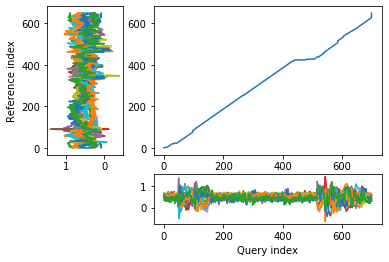

Stretch = 0.04
Distance  = 0.16
Correlation = 0.43


1        2        3        4        5        6        7   \
seg      We have    pause   really    pause  enjoyed    pause      the   
start 1  1.97932  2.39872  2.48859  2.90799  6.66262  7.25178  7.39158   
start 2  1.76961  2.18902  2.34879  2.77817  5.87375  6.46291  6.69258   
len 1       0.42     0.09     0.42     3.75     0.59     0.14     0.06   
len 2       0.42     0.16     0.43     3.10     0.59     0.23     0.06   
stretch     0.00     0.38     0.02     0.13     0.09     0.33     0.00   

             8        9        10       11  
seg       pause      pro    pause     ject  
start 1  7.4515  7.57133  7.75107  7.85093  
start 2  6.7525  6.90228  7.06205  7.14194  
len 1      0.12     0.18     0.10     0.06  
len 2      0.15     0.16     0.08     0.06  
stretch    0.16     0.09     0.17     0.00

1      2       3      4        5      6     7      8     9   \
seg      We have  pause  really  pause  enjoyed  pause   the  pause   pro   
stretch     0.00   0.38    0.02   0.13     0.09   0.33  0.00   0.16  0.09   

            10    11  
seg      pause  ject  
stretch   0.17  0.00

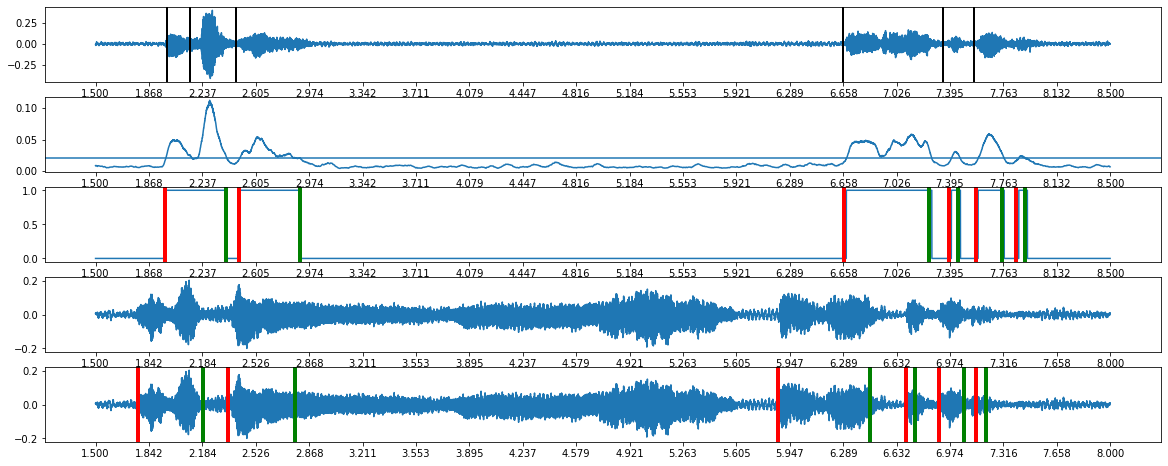

In [71]:
file1, seg1_1, seg1_2 = "report-pause1.wav", 1.5, 8.5
file2, seg2_1, seg2_2 = "report-longword2.wav", 1.5, 8

timelst1 = [1.99, 2.15, 2.47, 6.66, 7.35, 7.56]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.02,
      timelst1=timelst1, segments = segmentspause1)

# 25. pause1combo1

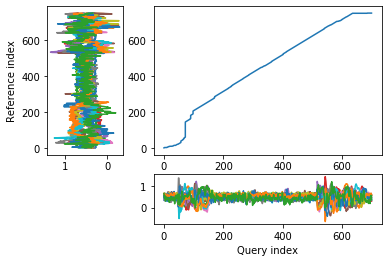

Stretch = 0.11
Distance  = 0.14
Correlation = 0.48


1        2        3        4        5        6        7   \
seg      We have    pause   really    pause  enjoyed    pause      the   
start 1  1.97932  2.39872  2.48859  2.90799  6.66262  7.25178  7.39158   
start 2   1.7097  3.13766  3.55706  3.97646  7.88088  8.46006  8.54993   
len 1       0.42     0.09     0.42     3.75     0.59     0.14     0.06   
len 2       1.43     0.42     0.42     3.90     0.58     0.09     0.03   
stretch     0.64     0.74     0.00     0.04     0.06     0.31     0.51   

              8        9        10       11  
seg        pause      pro    pause     ject  
start 1   7.4515  7.57133  7.75107  7.85093  
start 2  8.57989   8.7097  8.87946  8.97932  
len 1       0.12     0.18     0.10     0.06  
len 2       0.13     0.17     0.10     0.00  
stretch     0.06     0.04     0.00     1.00

1      2       3      4        5      6     7      8     9   \
seg      We have  pause  really  pause  enjoyed  pause   the  pause   pro   
stretch     0.64   0.74    0.00   0.04     0.06   0.31  0.51   0.06  0.04   

            10    11  
seg      pause  ject  
stretch   0.00  1.00

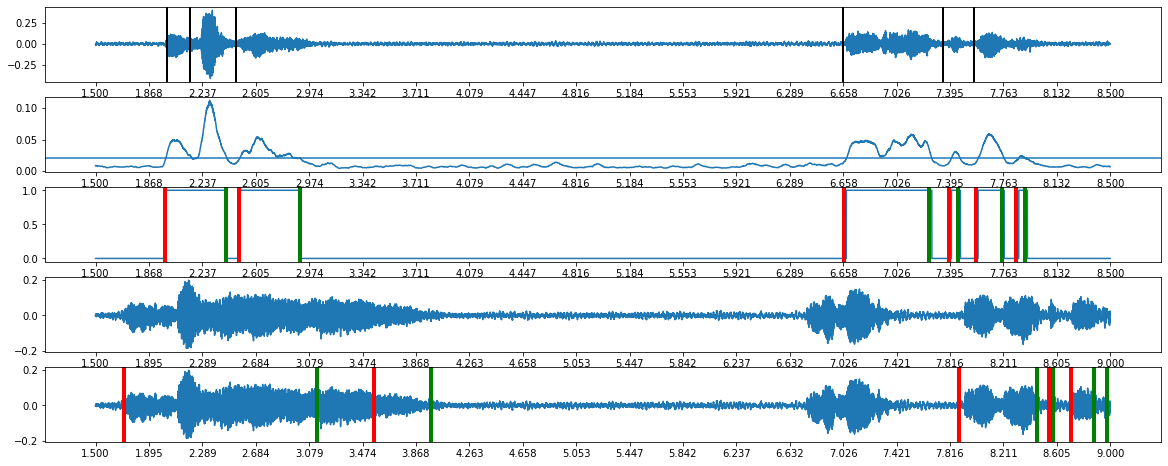

In [72]:
file1, seg1_1, seg1_2 = "report-pause1.wav", 1.5, 8.5
file2, seg2_1, seg2_2 = "report-combo1.wav", 1.5, 9

timelst1 = [1.99, 2.15, 2.47, 6.66, 7.35, 7.56]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.02,
      timelst1=timelst1, segments = segmentspause1)

# 26. pause1combo2

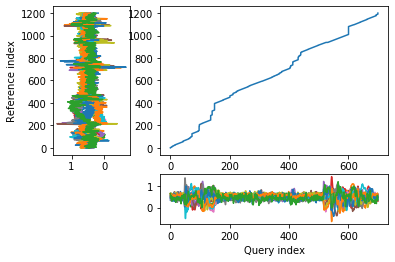

Stretch = 0.39
Distance  = 0.13
Correlation = 0.59


1        2        3        4        5        6        7   \
seg      We have    pause   really    pause  enjoyed    pause      the   
start 1  1.97932  2.39872  2.48859  2.90799  6.66262  7.25178  7.39158   
start 2  2.64907  3.42796  4.07703  4.92582  11.3067   11.826  11.9658   
len 1       0.42     0.09     0.42     3.75     0.59     0.14     0.06   
len 2       0.78     0.65     0.85     6.38     0.52     0.14     0.06   
stretch     0.38     0.83     0.43     0.34     0.09     0.00     0.00   

              8        9        10       11  
seg        pause      pro    pause     ject  
start 1   7.4515  7.57133  7.75107  7.85093  
start 2  12.0257  12.8545  13.0143  13.1241  
len 1       0.12     0.18     0.10     0.06  
len 2       0.83     0.16     0.11     0.07  
stretch     0.82     0.09     0.07     0.12

1      2       3      4        5      6     7      8     9   \
seg      We have  pause  really  pause  enjoyed  pause   the  pause   pro   
stretch     0.38   0.83    0.43   0.34     0.09   0.00  0.00   0.82  0.09   

            10    11  
seg      pause  ject  
stretch   0.07  0.12

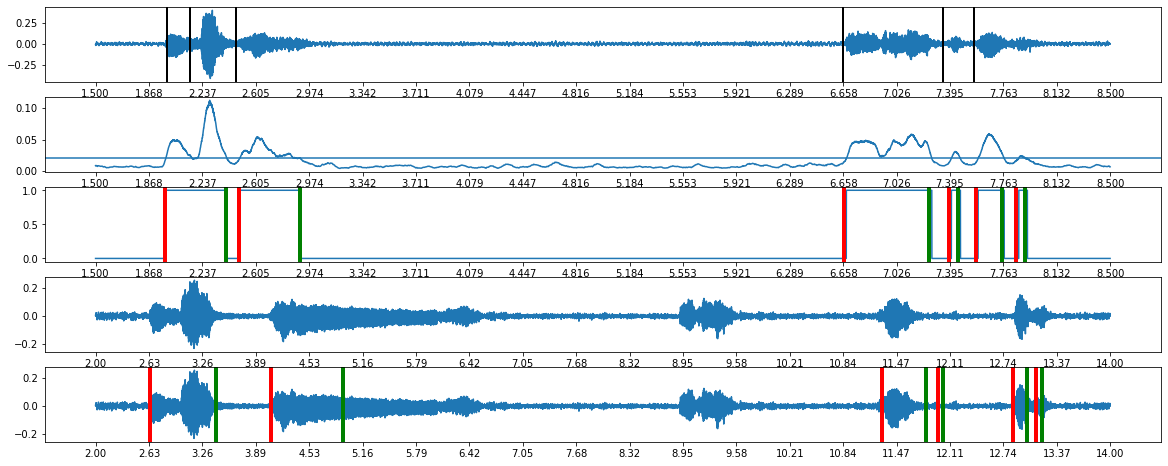

In [73]:
file1, seg1_1, seg1_2 = "report-pause1.wav", 1.5, 8.5
file2, seg2_1, seg2_2 = "report-combo2.wav", 2, 14

timelst1 = [1.99, 2.15, 2.47, 6.66, 7.35, 7.56]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.02,
      timelst1=timelst1, segments = segmentspause1)

# 27. pause2longword1

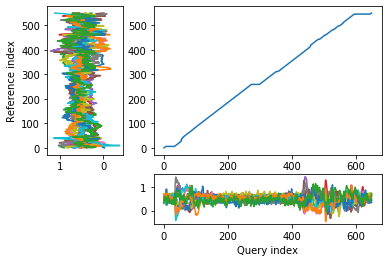

Stretch = 0.06
Distance  = 0.14
Correlation = 0.53


1        2          3        4        5        6        7   \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  2.34946  2.88863     6.3533  6.77266  6.83257   7.3318   7.4616   
start 2  1.57988  2.22888    5.39401  5.87327   5.9232  6.34255  6.47235   
len 1       0.54     3.46       0.42     0.06     0.50     0.13     0.05   
len 2       0.65     3.17       0.48     0.05     0.42     0.13     0.02   
stretch     0.13     0.07       0.09     0.00     0.12     0.00     0.68   

              8        9        10       11  
seg        pause      pro    pause     ject  
start 1  7.51152  7.62135  7.78111  7.93088  
start 2  6.49232  6.62212  6.78187  6.93164  
len 1       0.11     0.16     0.15     0.04  
len 2       0.13     0.16     0.15     0.02  
stretch     0.12     0.00     0.00     0.59

1      2          3      4      5      6     7      8     9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause   pro   
stretch     0.13   0.07       0.09   0.00   0.12   0.00  0.68   0.12  0.00   

            10    11  
seg      pause  ject  
stretch   0.00  0.59

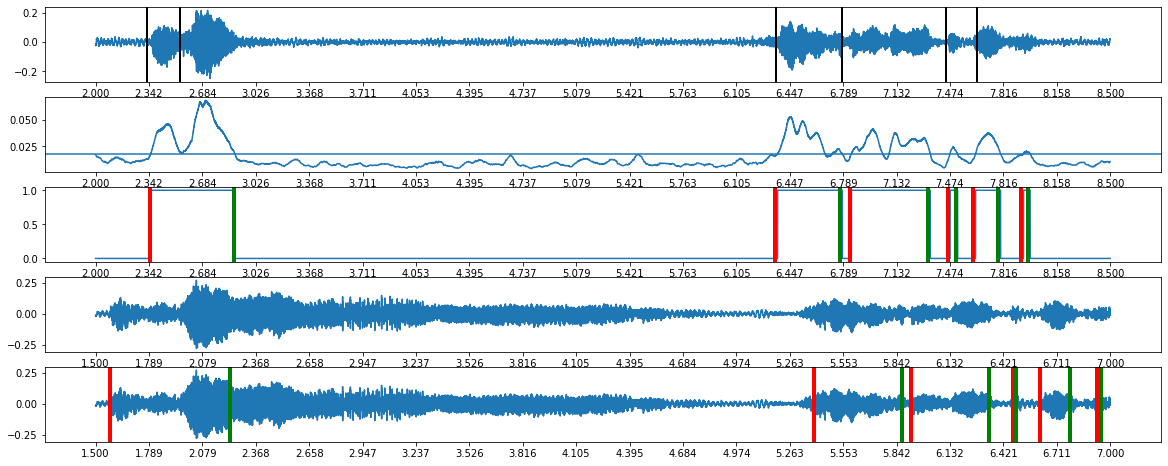

In [84]:
file1, seg1_1, seg1_2 = "report-pause2.wav", 2, 8.5
file2, seg2_1, seg2_2 = "report-longword1.wav", 1.5, 7

timelst1 = [2.33, 2.54, 6.36, 6.78, 7.45, 7.65]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.018,
      timelst1=timelst1, segments = segmentspause2)

# 28. pause2longword2

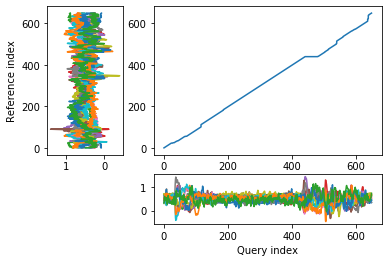

Stretch = 0.05
Distance  = 0.16
Correlation = 0.34


1        2          3        4        5       6       7   \
seg      We have    pause  really en    pause    joyed   pause     the   
start 1  2.34946  2.88863     6.3533  6.77266  6.83257  7.3318  7.4616   
start 2  1.77957  2.23886    5.83333  5.89324  5.91321  6.4424   6.702   
len 1       0.54     3.46       0.42     0.06     0.50    0.13    0.05   
len 2       0.46     3.59       0.06     0.02     0.53    0.26    0.05   
stretch     0.11     0.03       0.80     0.74     0.04    0.43    0.00   

              8        9        10       11  
seg        pause      pro    pause     ject  
start 1  7.51152  7.62135  7.78111  7.93088  
start 2  6.75192  6.88172  7.04147  7.18126  
len 1       0.11     0.16     0.15     0.04  
len 2       0.13     0.16     0.14     0.03  
stretch     0.12     0.00     0.05     0.26

1      2          3      4      5      6     7      8     9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause   pro   
stretch     0.11   0.03       0.80   0.74   0.04   0.43  0.00   0.12  0.00   

            10    11  
seg      pause  ject  
stretch   0.05  0.26

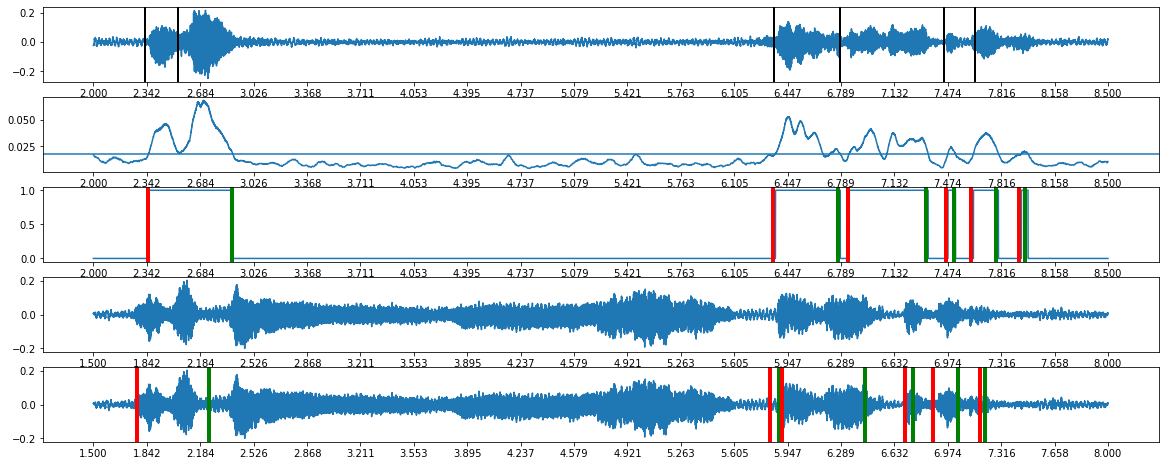

In [89]:
file1, seg1_1, seg1_2 = "report-pause2.wav", 2, 8.5
file2, seg2_1, seg2_2 = "report-longword2.wav", 1.5, 8

timelst1 = [2.33, 2.54, 6.36, 6.78, 7.45, 7.65]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.018,
      timelst1=timelst1, segments = segmentspause2)

# 29. pause2combo1

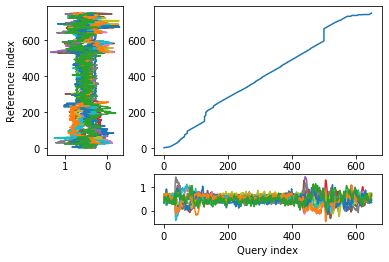

Stretch = 0.22
Distance  = 0.13
Correlation = 0.61


1        2          3        4        5        6        7   \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  2.34946  2.88863     6.3533  6.77266  6.83257   7.3318   7.4616   
start 2  1.71966  2.58833     6.7619  7.21121  7.27112  8.44931  8.55914   
len 1       0.54     3.46       0.42     0.06     0.50     0.13     0.05   
len 2       0.87     4.17       0.45     0.06     1.18     0.11     0.02   
stretch     0.31     0.13       0.05     0.00     0.50     0.12     0.41   

              8        9        10       11  
seg        pause      pro    pause     ject  
start 1  7.51152  7.62135  7.78111  7.93088  
start 2  8.57911  8.69892  8.80876  8.85868  
len 1       0.11     0.16     0.15     0.04  
len 2       0.12     0.11     0.05     0.00  
stretch     0.07     0.20     0.56     1.00

1      2          3      4      5      6     7      8     9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause   pro   
stretch     0.31   0.13       0.05   0.00   0.50   0.12  0.41   0.07  0.20   

            10    11  
seg      pause  ject  
stretch   0.56  1.00

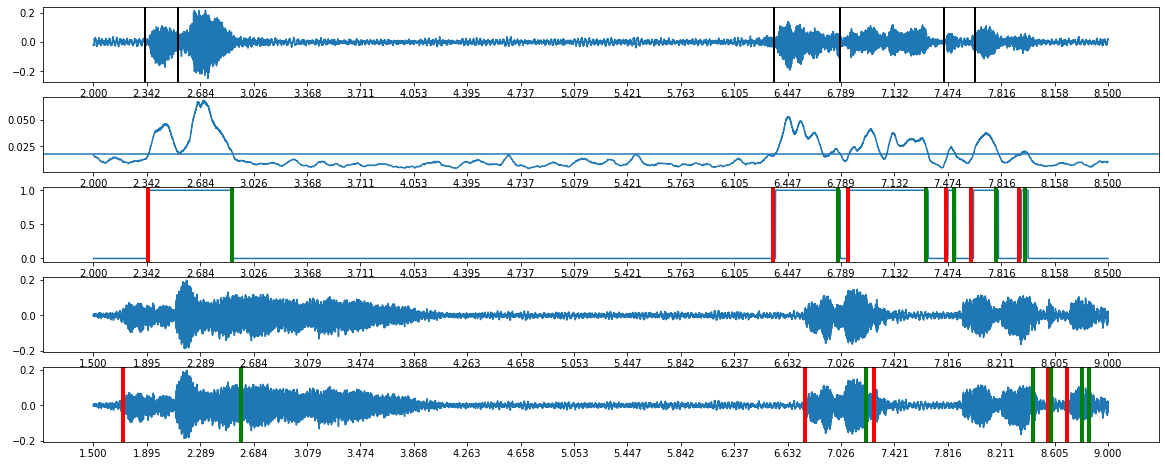

In [90]:
file1, seg1_1, seg1_2 = "report-pause2.wav", 2, 8.5
file2, seg2_1, seg2_2 = "report-combo1.wav", 1.5, 9

timelst1 = [2.33, 2.54, 6.36, 6.78, 7.45, 7.65]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.018,
      timelst1=timelst1, segments = segmentspause2)

# 30. pause2combo2

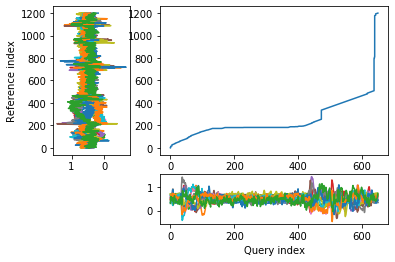

Stretch = 0.61
Distance  = 0.13
Correlation = 0.55


1        2          3        4        5       6       7   \
seg      We have    pause  really en    pause    joyed   pause     the   
start 1  2.34946  2.88863     6.3533  6.77266  6.83257  7.3318  7.4616   
start 2    2.649  3.32796    4.11674  5.40476  5.46467  5.9639  6.0937   
len 1       0.54     3.46       0.42     0.06     0.50    0.13    0.05   
len 2       0.68     0.79       1.29     0.06     0.50    0.13    0.05   
stretch     0.16     0.72       0.60     0.00     0.00    0.00    0.00   

              8        9        10       11  
seg        pause      pro    pause     ject  
start 1  7.51152  7.62135  7.78111  7.93088  
start 2  6.14363  6.25346  6.41321  6.56298  
len 1       0.11     0.16     0.15     0.04  
len 2       0.11     0.16     0.15     0.04  
stretch     0.00     0.00     0.00     0.00

1      2          3      4      5      6     7      8     9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause   pro   
stretch     0.16   0.72       0.60   0.00   0.00   0.00  0.00   0.00  0.00   

            10    11  
seg      pause  ject  
stretch   0.00  0.00

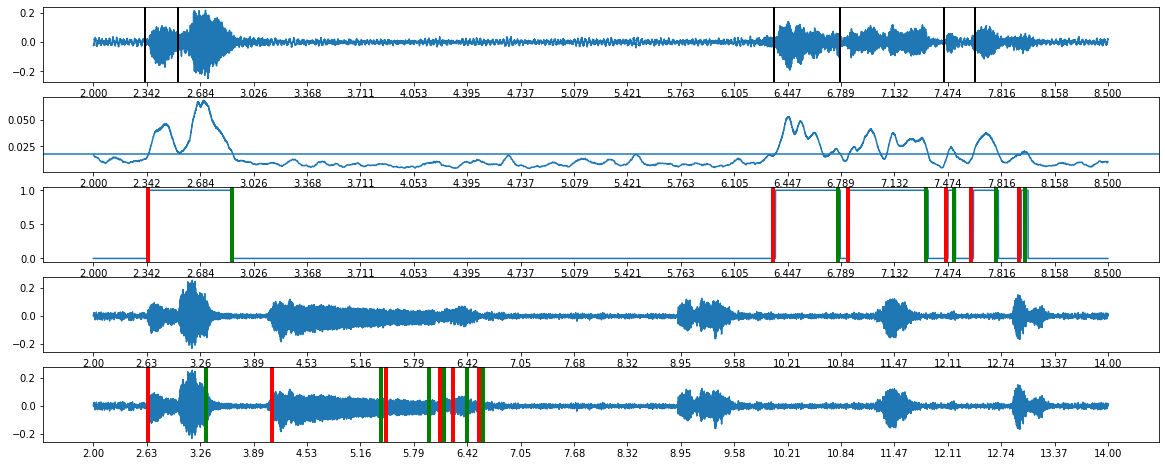

In [91]:
file1, seg1_1, seg1_2 = "report-pause2.wav", 2, 8.5
file2, seg2_1, seg2_2 = "report-combo2.wav", 2, 14

timelst1 = [2.33, 2.54, 6.36, 6.78, 7.45, 7.65]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.018,
      timelst1=timelst1, segments = segmentspause2)

# 31. longword1longword2

In [100]:
segmentslongword1 = ['We have', 'pause', 'pause', 'pause', 'really enjoyed', 'pause', 'the', 'pause', 'pro', 'pause', 'ject', 'pause', '','', '']

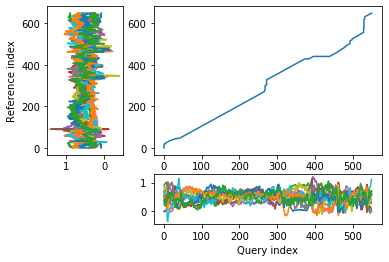

Stretch = 0.14
Distance  = 0.17
Correlation = 0.37


1        2        3        4               5        6        7   \
seg      We have    pause    pause    pause  really enjoyed    pause      the   
start 1  1.56987  4.55445   5.0735  5.11343         5.32305  6.35118    6.451   
start 2  1.75953  5.11343  5.63249  5.67241         5.78221    6.451  6.68058   
len 1       2.98     0.52     0.04     0.21            1.03     0.10     0.06   
len 2       3.35     0.52     0.04     0.11            0.67     0.23     0.10   
stretch     0.14     0.00     0.00     0.37            0.39     0.51     0.36   

              8        9        10       11  
seg        pause      pro    pause     ject  
start 1  6.51089  6.61071  6.80036  6.92015  
start 2   6.7804  6.88022  7.68875  7.91833  
len 1       0.10     0.19     0.12     0.05  
len 2       0.10     0.81     0.23     0.05  
stretch     0.00     0.71     0.41     0.00

1      2      3      4               5      6     7      8   \
seg      We have  pause  pause  pause  really enjoyed  pause   the  pause   
stretch     0.14   0.00   0.00   0.37            0.39   0.51  0.36   0.00   

           9      10    11  
seg       pro  pause  ject  
stretch  0.71   0.41  0.00

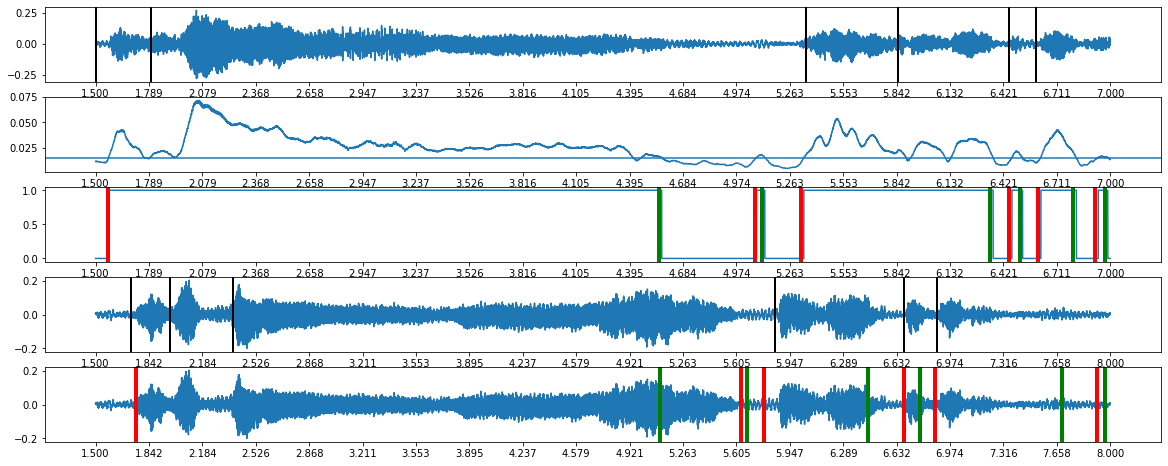

In [102]:
file1, seg1_1, seg1_2 = "report-longword1.wav", 1.5, 7
file2, seg2_1, seg2_2 = "report-longword2.wav", 1.5, 8

timelst1 = [1.5, 1.80, 5.35, 5.85, 6.45, 6.6]
timelst2 = [1.73, 1.98, 2.38, 5.85, 6.68, 6.89]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.015, timelst2=timelst2,
      timelst1=timelst1, segments = segmentslongword1)

# 32. longword1combo1

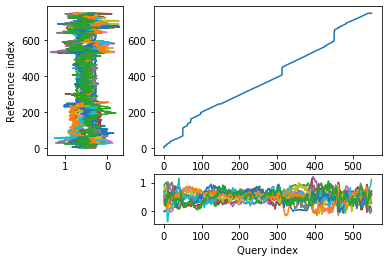

Stretch = 0.30
Distance  = 0.13
Correlation = 0.64


1        2        3        4               5        6        7   \
seg      We have    pause    pause    pause  really enjoyed    pause      the   
start 1  1.56987  4.55445   5.0735  5.11343         5.32305  6.35118    6.451   
start 2  1.65971  5.48276  6.43103  6.47096         6.69056  8.45735  8.54719   
len 1       2.98     0.52     0.04     0.21            1.03     0.10     0.06   
len 2       3.82     0.95     0.04     0.22            1.77     0.09     0.05   
stretch     0.19     0.37     0.00     0.03            0.35     0.08     0.15   

              8        9        10       11  
seg        pause      pro    pause     ject  
start 1  6.51089  6.61071  6.80036  6.92015  
start 2   8.5971  8.68693  8.87659  8.97641  
len 1       0.10     0.19     0.12     0.05  
len 2       0.09     0.19     0.10     0.00  
stretch     0.08     0.00     0.07     1.00

1      2      3      4               5      6     7      8   \
seg      We have  pause  pause  pause  really enjoyed  pause   the  pause   
stretch     0.19   0.37   0.00   0.03            0.35   0.08  0.15   0.08   

           9      10    11  
seg       pro  pause  ject  
stretch  0.00   0.07  1.00

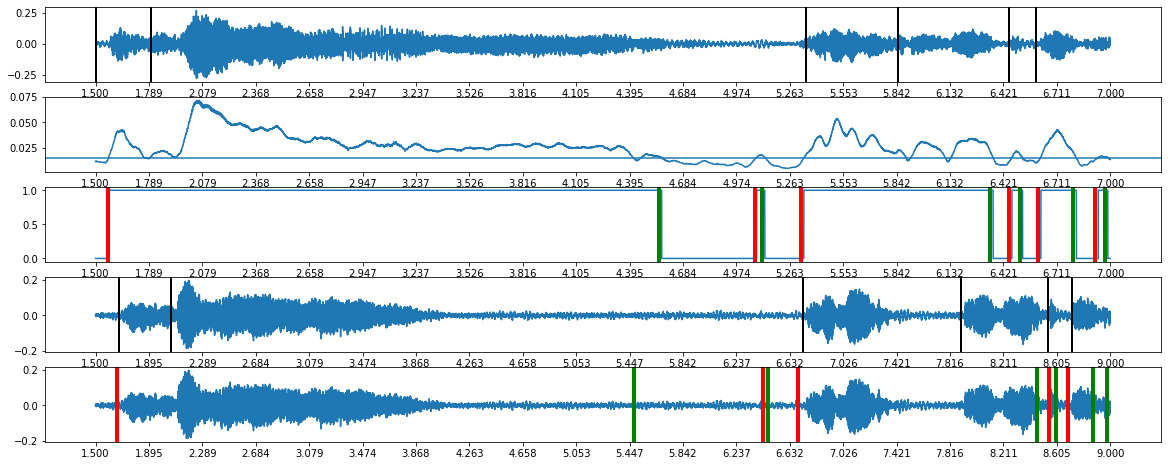

In [103]:
file1, seg1_1, seg1_2 = "report-longword1.wav", 1.5, 7
file2, seg2_1, seg2_2 = "report-combo1.wav", 1.5, 9

timelst1 = [1.5, 1.80, 5.35, 5.85, 6.45, 6.6]
timelst2 = [1.67, 2.06, 6.73, 7.9, 8.54, 8.72]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.015, timelst2=timelst2,
      timelst1=timelst1, segments = segmentslongword1)

# 33. longword1combo2

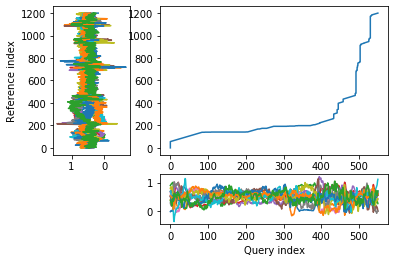

Stretch = 0.64
Distance  = 0.16
Correlation = 0.55


1        2        3        4               5        6        7   \
seg      We have    pause    pause    pause  really enjoyed    pause      the   
start 1  1.56987  4.55445   5.0735  5.11343         5.32305  6.35118    6.451   
start 2  2.62886  3.91652  3.97641  3.97641         4.05626  6.61162  9.15699   
len 1       2.98     0.52     0.04     0.21            1.03     0.10     0.06   
len 2       1.29     0.06     0.00     0.08            2.56     2.55     0.47   
stretch     0.49     0.84     1.00     0.52            0.52     0.95     0.85   

              8        9        10       11  
seg        pause      pro    pause     ject  
start 1  6.51089  6.61071  6.80036  6.92015  
start 2  9.62613  11.2931  13.6987  13.9083  
len 1       0.10     0.19     0.12     0.05  
len 2       1.67     2.41     0.21     0.05  
stretch     0.93     0.90     0.37     0.00

1      2      3      4               5      6     7      8   \
seg      We have  pause  pause  pause  really enjoyed  pause   the  pause   
stretch     0.49   0.84   1.00   0.52            0.52   0.95  0.85   0.93   

           9      10    11  
seg       pro  pause  ject  
stretch  0.90   0.37  0.00

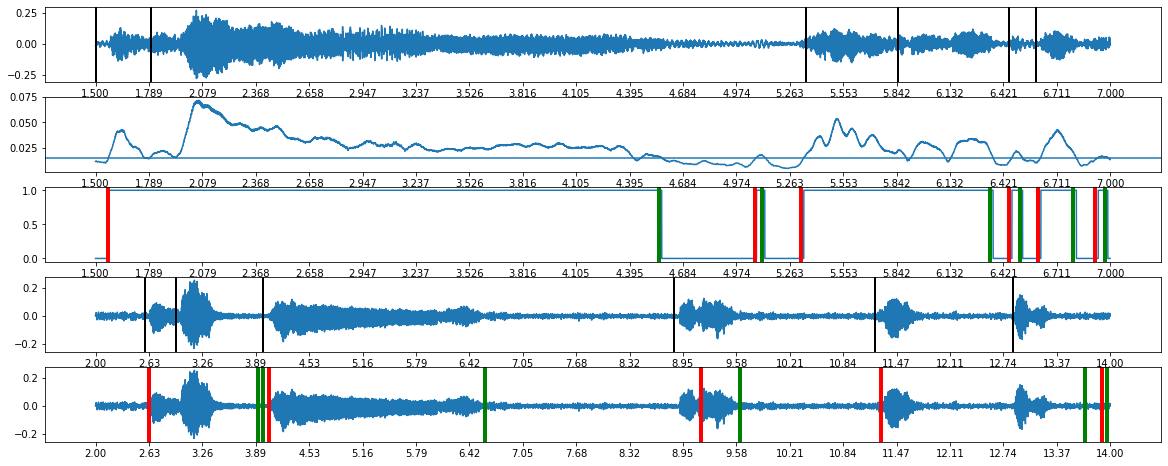

In [104]:
file1, seg1_1, seg1_2 = "report-longword1.wav", 1.5, 7
file2, seg2_1, seg2_2 = "report-combo2.wav", 2, 14

timelst1 = [1.5, 1.80, 5.35, 5.85, 6.45, 6.6]
timelst2 = [2.58, 2.95, 3.98, 8.84, 11.22, 12.85]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.015, timelst2=timelst2,
      timelst1=timelst1, segments = segmentslongword1)

# 34. longword2combo1

In [117]:
segmentslongword2 = ['We', 'pause', 'have', 'pause', 'rea', 'pause', 'lly', 'pause', 'enjoyed', 'pause',  'the', 'pause', 'pro', 'pause', 'ject', 'pause', '','', '']

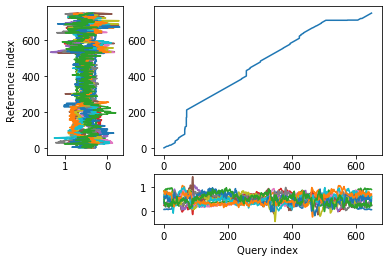

Stretch = 0.27
Distance  = 0.16
Correlation = 0.39


1        2        3        4        5        6        7   \
seg           We    pause     have    pause      rea    pause      lly   
start 1  1.76959  1.93932  1.98925  2.15899   2.2788   2.9278  3.82642   
start 2  1.70968  1.98925  2.08909  2.55837  3.67665  4.32565  5.22427   
len 1       0.17     0.05     0.17     0.12     0.65     0.90     1.66   
len 2       0.28     0.10     0.47     1.12     0.65     0.90     2.12   
stretch     0.33     0.47     0.57     0.87     0.00     0.00     0.16   

              8        9        10       11       12       13  
seg        pause  enjoyed    pause      the    pause      pro  
start 1  5.48387   5.8533  6.47235  6.69201  6.79186  6.90169  
start 2  7.34101  7.86022  8.49923  8.58909  8.58909  8.58909  
len 1       0.37     0.62     0.22     0.10     0.11     0.13  
len 2       0.52     0.64     0.09     0.00     0.00     0.00  
stretch     0.23     0.07     0.49     1.00     1.00     1.00

1      2     3      4     5      6     7      8        9      10  \
seg        We  pause  have  pause   rea  pause   lly  pause  enjoyed  pause   
stretch  0.33   0.47  0.57   0.87  0.00   0.00  0.16   0.23     0.07   0.49   

           11     12    13  
seg       the  pause   pro  
stretch  1.00   1.00  1.00

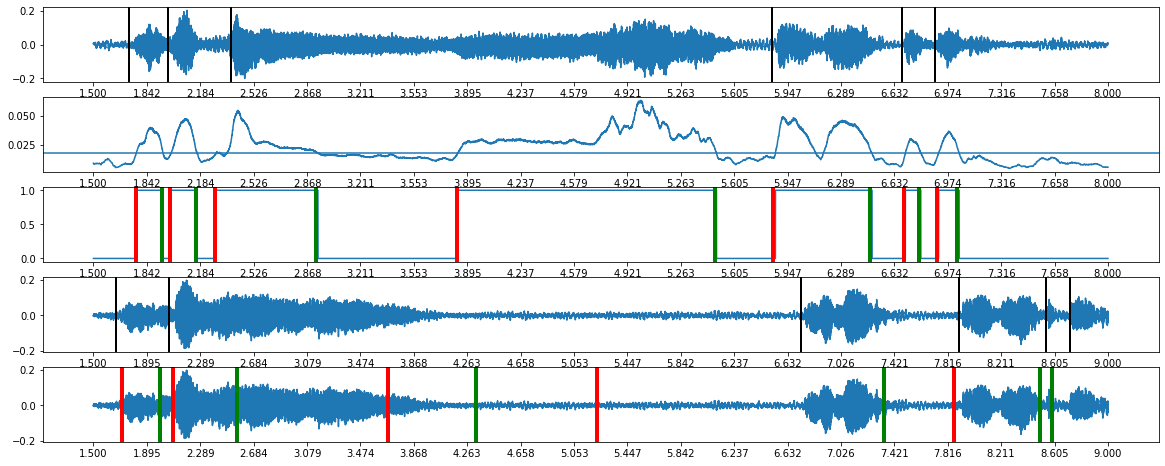

In [118]:
file1, seg1_1, seg1_2 = "report-longword2.wav", 1.5, 8
file2, seg2_1, seg2_2 = "report-combo1.wav", 1.5, 9

timelst1 = [1.73, 1.98, 2.38, 5.85, 6.68, 6.89]
timelst2 = [1.67, 2.06, 6.73, 7.9, 8.54, 8.72]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.018, timelst2=timelst2,
      timelst1=timelst1, segments = segmentslongword2)

# 35. longword2combo2

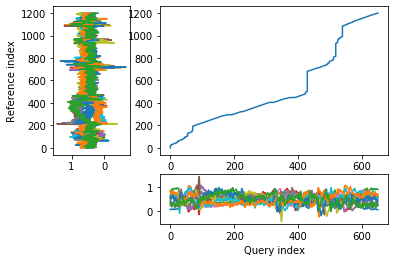

Stretch = 0.52
Distance  = 0.13
Correlation = 0.72


1        2          3        4        5        6        7   \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.77957  1.92934    1.99923    2.149  2.36866  2.82796  3.84639   
start 2    2.649  2.85868    3.00845  3.39785  4.09677  4.55607  5.30492   
len 1       0.15     0.07       0.15     0.22     0.46     1.02     1.63   
len 2       0.21     0.15       0.39     0.70     0.46     0.75     1.24   
stretch     0.23     0.49       0.55     0.62     0.00     0.21     0.18   

              8        9        10       11       12       13       14  \
seg        pause      pro    pause     ject    pause     ject            
start 1  5.47389  5.86329  6.10292  6.17281  6.46237    6.702  6.77189   
start 2  6.54301  8.87942  9.08909  9.15899  9.55837  11.3257  11.6851   
len 1       0.39     0.24     0.07     0.29     0.24     0.07     0.14   
len 2       2.34     0.21     0.07     0.40     1.77     0.36     1.17   
stretch     0.78     0.06     0.00     0.22     0.82     0.77     0.85   

              15  
seg               
start 1  6.91167  
start 2  12.8533  
len 1       0.11  
len 2       0.12  
stretch     0.07

1      2          3      4      5      6     7      8     9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause   pro   
stretch     0.23   0.49       0.55   0.62   0.00   0.21  0.18   0.78  0.06   

            10    11     12    13    14    15  
seg      pause  ject  pause  ject              
stretch   0.00  0.22   0.82  0.77  0.85  0.07

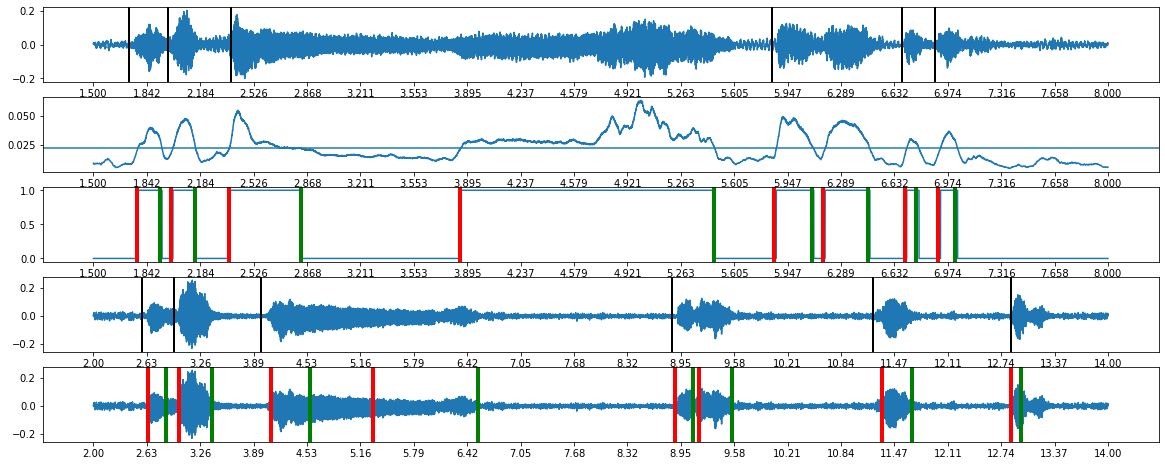

In [119]:
file1, seg1_1, seg1_2 = "report-longword2.wav", 1.5, 8
file2, seg2_1, seg2_2 = "report-combo2.wav", 2, 14

timelst1 = [1.73, 1.98, 2.38, 5.85, 6.68, 6.89]
timelst2 = [2.58, 2.95, 3.98, 8.84, 11.22, 12.85]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.022, timelst2=timelst2,
      timelst1=timelst1, segments = segmentspause2)

# 36. combo1combo2

In [124]:
segmentscombo1 = ['We', 'pause', 'have', 'pause', 'really', 'pause', 'en', 'pause', 'joyed', 'pause', 'project', 'pause', 'pro', 'pause', 'ject', 'pause', '','', '']

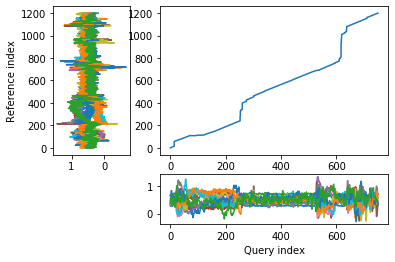

Stretch = 0.50
Distance  = 0.15
Correlation = 0.41


1        2        3        4        5        6        7   \
seg           We    pause     have    pause   really    pause       en   
start 1  1.72969  1.92943   2.0992  3.55726  6.76298  7.30226  7.92144   
start 2  2.66911  2.82889  2.99867  3.93742  8.88083  9.38016  12.8356   
len 1       0.20     0.17     1.46     3.21     0.54     0.62     0.22   
len 2       0.16     0.17     0.94     4.94     0.50     3.46     0.22   
stretch     0.16     0.00     0.28     0.30     0.11     0.77     0.00   

              8        9        10       11  
seg        pause    joyed    pause  project  
start 1  8.14115  8.20107  8.45073  8.71039  
start 2  13.0553  13.1152  13.3648  13.7044  
len 1       0.06     0.25     0.26     0.16  
len 2       0.06     0.25     0.34     0.16  
stretch     0.00     0.00     0.18     0.00

1      2     3      4       5      6     7      8      9      10  \
seg        We  pause  have  pause  really  pause    en  pause  joyed  pause   
stretch  0.16   0.00  0.28   0.30    0.11   0.77  0.00   0.00   0.00   0.18   

              11  
seg      project  
stretch     0.00

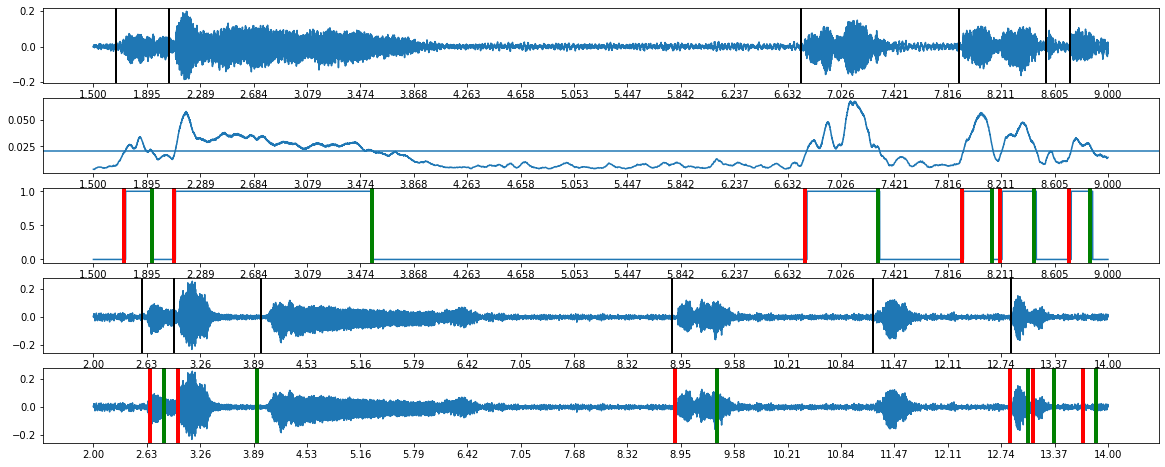

In [125]:
file1, seg1_1, seg1_2 = "report-combo1.wav", 1.5, 9
file2, seg2_1, seg2_2 = "report-combo2.wav", 2, 14

timelst1 = [1.67, 2.06, 6.73, 7.9, 8.54, 8.72]
timelst2 = [2.58, 2.95, 3.98, 8.84, 11.22, 12.85]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.021, timelst2=timelst2,
      timelst1=timelst1, segments = segmentscombo1)